In [2]:
%who

Interactive namespace is empty.


In [3]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import datetime
import matplotlib
import seaborn as sns

# getting the spatial plotting function from another directory
import sys
new_path = '/home/566/ad9701/drought_probability/final_code_AU/'
if new_path not in sys.path:
    sys.path.append(new_path)
import validation_functions as myfuncs
%run -i drought_2017to2019/dataInfo_and_functions.py

import matplotlib.pyplot as plt
import pandas as pd

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Read data & create monthly anomaly plots by basin using all gauges in the basin

Basin = Gwydir
[0, 0, 0, 0, 0, 0, 0, 0]
[Timestamp('1970-03-20 00:00:00'), Timestamp('1979-05-26 00:00:00'), Timestamp('1978-11-30 00:00:00'), Timestamp('1970-09-12 00:00:00'), Timestamp('1977-07-30 00:00:00'), Timestamp('1970-10-15 00:00:00'), Timestamp('1970-07-02 00:00:00'), Timestamp('1978-06-15 00:00:00')]
------------------------------------------------
Basin = Murrumbidgee
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Timestamp('1974-11-14 00:00:00'), Timestamp('1964-03-01 00:00:00'), Timestamp('1961-04-08 00:00:00'), Timestamp('1961-02-16 00:00:00'), Timestamp('1950-12-02 00:00:00'), Timestamp('1950-01-01 00:00:00'), Timestamp('1964-11-14 00:00:00'), Timestamp('1964-06-02 00:00:00'), Timestamp('1957-05-25 00:00:00'), Timestamp('1966-08-04 00:00:00'), Timestamp('1950-01-01 00:00:00'), Timestamp('1959-08-01 00:00:00'), Timestamp('1967-06-02 00:00:00'), Timestamp('1957-03-31 00:00:00'), Timestamp('1982-05-22 00:00:00'), Timestamp('1950-01-01 00:00:00'), Timestamp('198

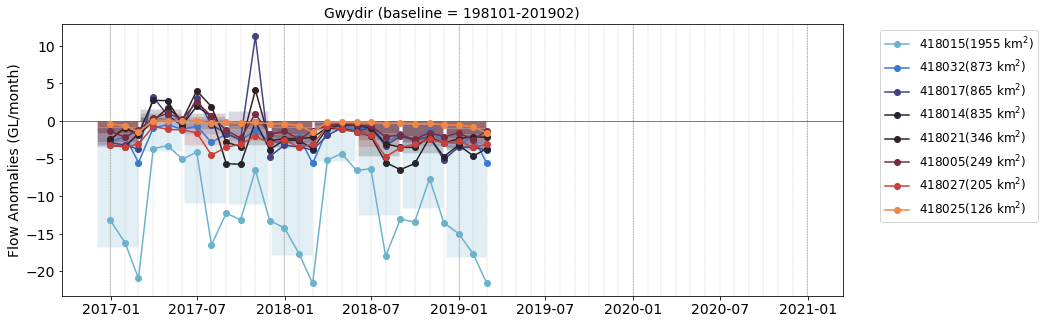

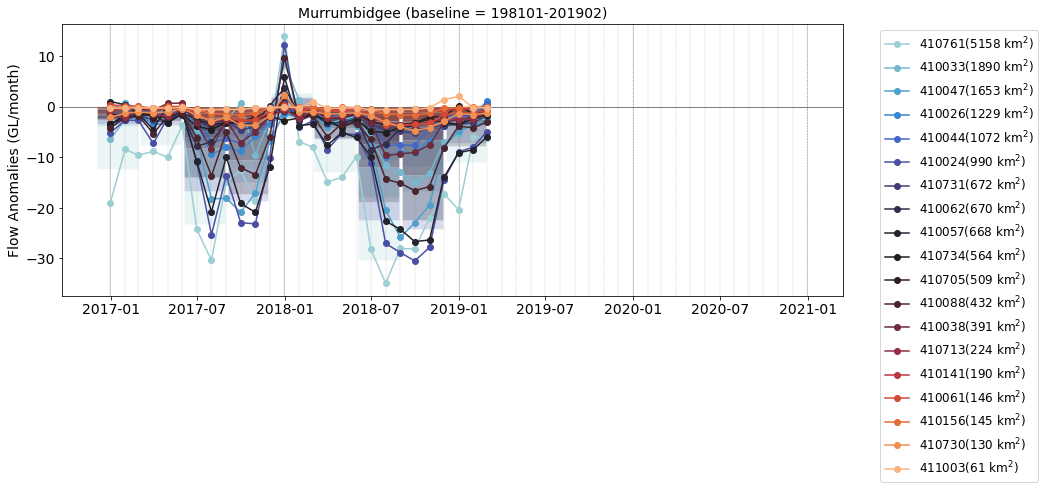

In [167]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/HRS_data/'
fig_dir = 'figures/drought_2017to2020/streamflow/'

stn_file = 'hrs_stations_test.csv'
df_stn = pd.read_csv(data_dir + stn_file)
# df_stn.head()
df_stn = df_stn.sort_values(by = "Catchment Area (km2)", ascending = False)

stn_Nos = df_stn['AWRC Statiion Number'].values

# All the basins in the file
basin_list = np.unique(df_stn['Basin'].values)

baseline = slice('1981-01-01', '2020-05-31')
fig_suffix = 'ref_198101_202005'
ref_title = 'baseline = 198101-201902'

# baseline = slice('1996-01-01', '2020-05-31')
# fig_suffix = 'ref_199601_202005'
# ref_title = 'baseline = 199601-201902'

# the timeslice of interest for monthly data
time_slice = slice('2016-12-01', '2020-12-31')
vname = 'Flow'

# read in the streamflow data using the read_csv function by specifying a header
for basin_sel in basin_list:
    stn_Nos_basin = df_stn['AWRC Statiion Number'].values[df_stn['Basin'] == basin_sel]

    # list containing data for all stations
    list_ds = []

    # some check arrays
    list_count_nan = []
    list_start_date = []

    for iStn in range(len(stn_Nos_basin)):
        test_file = data_dir + str(stn_Nos_basin[iStn]) + '_daily_ts.csv'
        df_test = pd.read_csv(test_file, header = 26)

        # get dates in format datetime64
        date_array = pd.date_range(df_test['Date'][0], periods=len(df_test), freq="D")
        df_test['Date'] = date_array
        list_start_date.append(df_test['Date'][0])

        df_test = df_test.set_index(['Date'])
        # print(df_test['Date'].values[-1])  # to check that the timeseries all end consistently on 28 Feb 2022

        list_count_nan.append(sum(np.isnan(df_test['Flow (ML)'].values)))
        da_test = df_test.to_xarray().rename({'Flow (ML)': 'Flow'})
        
        # The record at some gauges starts mid-year at a year later than 1981, so the data needs to be sliced to avoid incorrect monthly totals
        if da_test['Date.year'][0].values > 1981:
            start_year = da_test['Date.year'][0].values
            da_test = da_test.sel(Date = slice(str(start_year+1)+'-01-01',None))
        list_ds.append(da_test)

    # create an xarray data array containing the data at all the stations
    ds_flow = xr.concat(list_ds, dim = 'station').assign_coords({'station': stn_Nos_basin}).rename({'Date': 'time'})
    ds_flow['Flow'] = ds_flow['Flow'].assign_attrs({'units': 'ML'})
    ds_flow = ds_flow.assign_attrs({'Source': 'http://www.bom.gov.au/water/hrs/'})
    
    print('Basin = ' + basin_sel)
    print(list_count_nan)
    print(list_start_date)
    print('------------------------------------------------')
    
    da_flow_mon = ds_flow[vname].resample(time = '1M').sum()
    # the monthly climatology from long-term data
    # the monthly anomalies during the drought period
    da_flow_lt_monClim = da_flow_mon.sel(time = baseline).groupby('time.month').mean('time')
    da_flow_monAnom = ((da_flow_mon.sel(time = time_slice).groupby('time.month') - da_flow_lt_monClim)/1000).assign_attrs({'units': 'GL'})

    ###################################
    # MONTHLY PLOT (may not be completely relevan, but will save in case
    ###################################
    
    nStations = len(da_flow_monAnom.station.values)
    # col_sel = sns.color_palette()[0:nStations]
    col_sel = sns.color_palette("icefire", nStations)
    

    data_list = [da_flow_monAnom.sel(station = s) for s in da_flow_monAnom.station.values]
    data_names = [str(x) + '(' + str(round(y)) + ' km$^2$)' for (x,y) in zip(da_flow_monAnom.station.values, df_stn['Catchment Area (km2)'].values[df_stn['Basin'] == basin_sel])]

    fig, ax = plt.subplots(nrows=1,ncols=1,
                        figsize=(14,5)) #width, height

    seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
    year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

    for xline in seas_breaks:
        plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
    for xline in year_breaks:
        plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

    plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
    for da, color, label in zip(data_list, col_sel, data_names):       
        plt.plot(da.time.values, da.values, marker='o', color=color, label=label)

        xx = da.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
        array_time = [x.astype('datetime64[D]') for x in xx]
        array_val = da.resample(time="QS-DEC").mean().values
        plt.bar(array_time, array_val, width=85, edgecolor='white', color=color, alpha=0.2)
            
    plt.xlabel('')
    plt.ylabel('Flow Anomalies (GL/month)')
    plt.title(basin_sel + ' (' + ref_title + ')')
    #plt.ylim((-40, 40))
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    fig.savefig(fig_dir + 'Q_anom_from_monClim_' + basin_sel + '_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
    fig.savefig(fig_dir + 'Q_anom_from_monClim_' + basin_sel + '_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')

### Read data & create monthly climatology plots by basin using all gauges in the basin

Basin = Gwydir
[0, 0, 0, 0, 0, 0, 0, 0]
[Timestamp('1970-03-20 00:00:00'), Timestamp('1979-05-26 00:00:00'), Timestamp('1978-11-30 00:00:00'), Timestamp('1970-09-12 00:00:00'), Timestamp('1977-07-30 00:00:00'), Timestamp('1970-10-15 00:00:00'), Timestamp('1970-07-02 00:00:00'), Timestamp('1978-06-15 00:00:00')]
------------------------------------------------
Basin = Murrumbidgee
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Timestamp('1974-11-14 00:00:00'), Timestamp('1964-03-01 00:00:00'), Timestamp('1961-04-08 00:00:00'), Timestamp('1961-02-16 00:00:00'), Timestamp('1950-12-02 00:00:00'), Timestamp('1950-01-01 00:00:00'), Timestamp('1964-11-14 00:00:00'), Timestamp('1964-06-02 00:00:00'), Timestamp('1957-05-25 00:00:00'), Timestamp('1966-08-04 00:00:00'), Timestamp('1950-01-01 00:00:00'), Timestamp('1959-08-01 00:00:00'), Timestamp('1967-06-02 00:00:00'), Timestamp('1957-03-31 00:00:00'), Timestamp('1982-05-22 00:00:00'), Timestamp('1950-01-01 00:00:00'), Timestamp('198

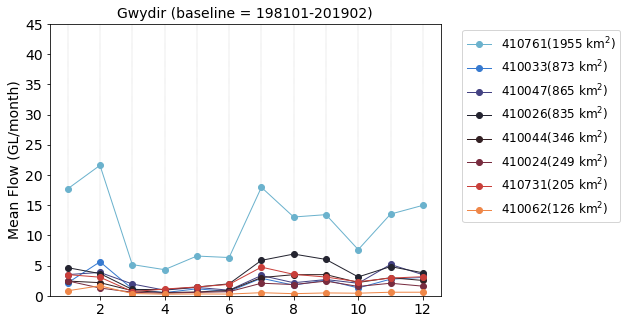

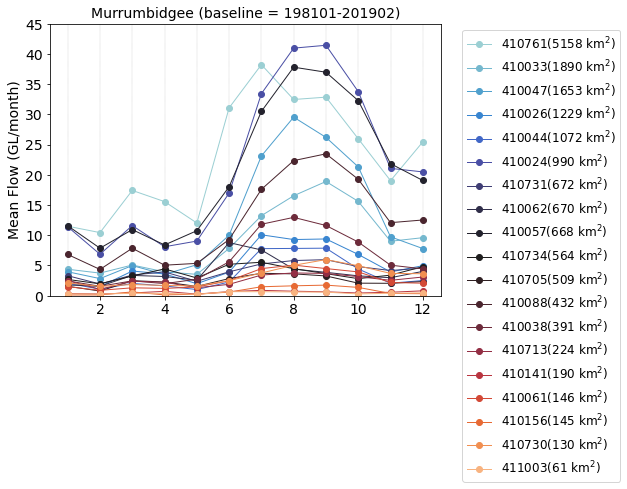

In [169]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/HRS_data/'
fig_dir = 'figures/drought_2017to2020/streamflow/'

stn_file = 'hrs_stations_test.csv'
df_stn = pd.read_csv(data_dir + stn_file)
# df_stn.head()
df_stn = df_stn.sort_values(by = "Catchment Area (km2)", ascending = False)

stn_Nos = df_stn['AWRC Statiion Number'].values

# All the basins in the file
basin_list = np.unique(df_stn['Basin'].values)

baseline = slice('1981-01-01', '2020-05-31')
fig_suffix = 'ref_198101_202005'
ref_title = 'baseline = 198101-201902'

# baseline = slice('1996-01-01', '2020-05-31')
# fig_suffix = 'ref_199601_202005'
# ref_title = 'baseline = 199601-201902'

# the timeslice of interest for monthly data
time_slice = slice('2016-12-01', '2020-12-31')
vname = 'Flow'

# read in the streamflow data using the read_csv function by specifying a header
for basin_sel in basin_list:
    stn_Nos_basin = df_stn['AWRC Statiion Number'].values[df_stn['Basin'] == basin_sel]

    # list containing data for all stations
    list_ds = []

    # some check arrays
    list_count_nan = []
    list_start_date = []

    for iStn in range(len(stn_Nos_basin)):
        test_file = data_dir + str(stn_Nos_basin[iStn]) + '_daily_ts.csv'
        df_test = pd.read_csv(test_file, header = 26)

        # get dates in format datetime64
        date_array = pd.date_range(df_test['Date'][0], periods=len(df_test), freq="D")
        df_test['Date'] = date_array
        list_start_date.append(df_test['Date'][0])

        df_test = df_test.set_index(['Date'])
        # print(df_test['Date'].values[-1])  # to check that the timeseries all end consistently on 28 Feb 2022

        list_count_nan.append(sum(np.isnan(df_test['Flow (ML)'].values)))
        da_test = df_test.to_xarray().rename({'Flow (ML)': 'Flow'})
        
        # The record at some gauges starts mid-year at a year later than 1981, so the data needs to be sliced to avoid incorrect monthly totals
        if da_test['Date.year'][0].values > 1981:
            start_year = da_test['Date.year'][0].values
            da_test = da_test.sel(Date = slice(str(start_year+1)+'-01-01',None))
        list_ds.append(da_test)

    # create an xarray data array containing the data at all the stations
    ds_flow = xr.concat(list_ds, dim = 'station').assign_coords({'station': stn_Nos_basin}).rename({'Date': 'time'})
    ds_flow['Flow'] = ds_flow['Flow'].assign_attrs({'units': 'ML'})
    ds_flow = ds_flow.assign_attrs({'Source': 'http://www.bom.gov.au/water/hrs/'})
    
    print('Basin = ' + basin_sel)
    print(list_count_nan)
    print(list_start_date)
    print('------------------------------------------------')
    
    da_flow_mon = ds_flow[vname].resample(time = '1M').sum()
    # the monthly climatology from long-term data
    da_flow_lt_monClim = (da_flow_mon.sel(time = baseline).groupby('time.month').mean('time')/1000).assign_attrs({'units': 'GL'})

    ###################################
    # MONTHLY CLIMATOLOGY PLOT (may not be completely relevant, but will save in case
    ###################################
    nStations = len(da_flow_lt_monClim.station.values)
    # col_sel = sns.color_palette()[0:nStations]
    col_sel = sns.color_palette("icefire", nStations)
    
    data_names = [str(x) + '(' + str(round(y)) + ' km$^2$)' for (x,y) in zip(da_flow_monAnom.station.values, df_stn['Catchment Area (km2)'].values[df_stn['Basin'] == basin_sel])]
    data_list = [da_flow_lt_monClim.sel(station = s) for s in da_flow_lt_monClim.station.values]
    
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(7,5)) #width, height
    
    for xline in range(1, 13):
        plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)

    for da, color, label in zip(data_list, col_sel, data_names):  
        plt.plot(da.month.values, da.values, color=color, marker="o", linewidth=1, label=label)
    plt.xlabel('month')
    plt.xlabel('')
    plt.ylabel('Mean Flow (GL/month)')
    plt.title(basin_sel + ' (' + ref_title + ')')
    plt.ylim((0, 45))
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    fig.savefig(fig_dir + 'Q_monClim_' + basin_sel + '_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
    fig.savefig(fig_dir + 'Q_monClim_' + basin_sel + '_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')

## Create seasonal anomaly plots combing data from mulitple basins
#### These figures would have to show percentage changes in streamflow w.r.t baseline

Basin = Gwydir
[0, 0, 0, 0, 0, 0, 0, 0]
[Timestamp('1970-03-20 00:00:00'), Timestamp('1979-05-26 00:00:00'), Timestamp('1978-11-30 00:00:00'), Timestamp('1970-09-12 00:00:00'), Timestamp('1977-07-30 00:00:00'), Timestamp('1970-10-15 00:00:00'), Timestamp('1970-07-02 00:00:00'), Timestamp('1978-06-15 00:00:00')]
------------------------------------------------
Basin = Murrumbidgee
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[Timestamp('1974-11-14 00:00:00'), Timestamp('1964-03-01 00:00:00'), Timestamp('1961-04-08 00:00:00'), Timestamp('1961-02-16 00:00:00'), Timestamp('1950-12-02 00:00:00'), Timestamp('1950-01-01 00:00:00'), Timestamp('1964-11-14 00:00:00'), Timestamp('1964-06-02 00:00:00'), Timestamp('1957-05-25 00:00:00'), Timestamp('1966-08-04 00:00:00'), Timestamp('1950-01-01 00:00:00'), Timestamp('1959-08-01 00:00:00'), Timestamp('1967-06-02 00:00:00'), Timestamp('1957-03-31 00:00:00'), Timestamp('1982-05-22 00:00:00'), Timestamp('1950-01-01 00:00:00'), Timestamp('198

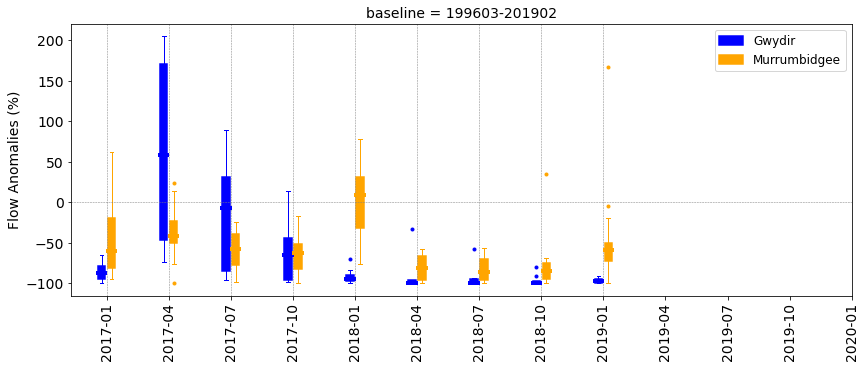

In [69]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/HRS_data/'
fig_dir = 'figures/drought_2017to2020/streamflow/'

stn_file = 'hrs_stations_test.csv'
df_stn = pd.read_csv(data_dir + stn_file)
# df_stn.head()
df_stn = df_stn.sort_values(by = "Catchment Area (km2)", ascending = False)

stn_Nos = df_stn['AWRC Statiion Number'].values

# All the basins in the file
basin_list = np.unique(df_stn['Basin'].values)

# baseline = slice('1981-03-01', '2020-05-31')  # adjusted the baseline for seasonal sum
# fig_suffix = 'ref_198103_202005'
# ref_title = 'baseline = 198103-201902'

baseline = slice('1996-03-01', '2020-05-31')  # adjusted the baseline for seasonal sum
fig_suffix = 'ref_199603_202005'
ref_title = 'baseline = 199603-201902'

# the timeslice of interest for monthly data
time_slice = slice('2016-12-01', '2020-11-30')  # adjusted the baseline for seasonal sum
vname = 'Flow'

# read in the streamflow data using the read_csv function by specifying a header
data_allBasins = []
for basin_sel in basin_list:
    stn_Nos_basin = df_stn['AWRC Statiion Number'].values[df_stn['Basin'] == basin_sel]

    # list containing data for all stations
    list_ds = []

    # some check arrays
    list_count_nan = []
    list_start_date = []

    for iStn in range(len(stn_Nos_basin)):
        test_file = data_dir + str(stn_Nos_basin[iStn]) + '_daily_ts.csv'
        df_test = pd.read_csv(test_file, header = 26)

        # get dates in format datetime64
        date_array = pd.date_range(df_test['Date'][0], periods=len(df_test), freq="D")
        df_test['Date'] = date_array
        list_start_date.append(df_test['Date'][0])

        df_test = df_test.set_index(['Date'])
        # print(df_test['Date'].values[-1])  # to check that the timeseries all end consistently on 28 Feb 2022

        list_count_nan.append(sum(np.isnan(df_test['Flow (ML)'].values)))
        da_test = df_test.to_xarray().rename({'Flow (ML)': 'Flow'})
        
        # The record at some gauges starts mid-year at a year later than 1981, so the data needs to be sliced to avoid incorrect monthly totals
        if da_test['Date.year'][0].values > 1981:
            start_year = da_test['Date.year'][0].values
            da_test = da_test.sel(Date = slice(str(start_year+1)+'-01-01',None))
        list_ds.append(da_test)

    # create an xarray data array containing the data at all the stations
    ds_flow = xr.concat(list_ds, dim = 'station').assign_coords({'station': stn_Nos_basin}).rename({'Date': 'time'})
    ds_flow['Flow'] = ds_flow['Flow'].assign_attrs({'units': 'ML'})
    ds_flow = ds_flow.assign_attrs({'Source': 'http://www.bom.gov.au/water/hrs/'})
    
    print('Basin = ' + basin_sel)
    print(list_count_nan)
    print(list_start_date)
    print('------------------------------------------------')
    
    da_flow_seas = ds_flow[vname].resample(time = "QS-DEC").sum()
    # the monthly climatology from long-term data
    # the monthly anomalies during the drought period
    da_flow_lt_seasClim = da_flow_seas.sel(time = baseline).groupby('time.season').mean('time')
    da_flow_seasSel = da_flow_seas.sel(time = time_slice)
    seasArray = da_flow_seasSel['time.season'].values
    da_seasClim_for_diff = da_flow_lt_seasClim.sel(season = seasArray).rename({'season':'time'}).assign_coords({'time':da_flow_seasSel.time.values})

    da_for_plot = ((da_flow_seasSel - da_seasClim_for_diff)/da_seasClim_for_diff*100).assign_attrs({'units': '%'})
    data_allBasins.append(da_for_plot)
    

xx = data_allBasins[0].time.values + np.timedelta64(45, 'D')
str_time = [x.astype('datetime64[M]').astype('str') for x in xx]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-01', freq='QS-DEC', periods=3*4+1).to_numpy() + np.timedelta64(45, 'D')#.astype(float)
str_time_longer = [x.astype('datetime64[M]').astype('str') for x in seas_breaks]
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

# for xline in seas_breaks:
#     plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
# for xline in year_breaks:
#     plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

tick_locs_x = np.arange(len(da_for_plot[0].time.values))
x1 = tick_locs_x - 0.08
x2 = tick_locs_x + 0.08
data_x_list = [x1, x2]

bp_leg = []
col_sel = ['blue', 'orange']
for x, y, color, group in zip(data_x_list, data_allBasins, col_sel, basin_list):
    bp = plt.boxplot(y.values, positions=x, sym='.', widths=0.12, patch_artist=True) #, notch = True)
    myfuncs.set_box_color(bp, color)
    bp_leg.append(bp["boxes"][0])  

plt.legend(bp_leg, basin_list, loc='upper right')

for p in [0]:
    ax.axhline(y=p, linestyle='--', color = 'gray', linewidth=0.5)
for p in tick_locs_x:
    ax.axvline(x=p, linestyle='--', color = 'gray', linewidth=0.5)

tick_locs_x_longer = np.arange(len(seas_breaks))
ax.set_xticks(tick_locs_x_longer, rotation = 90) 
ax.set_xticklabels(str_time_longer, rotation = 90)

plt.ylabel('Flow Anomalies (%)')
plt.title(ref_title)

fig.savefig(fig_dir + 'Q_anom_from_seasClim_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'Q_anom_from_seasClim_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')

### Considering only the bigger catchments (Area ~1000 km^2 or larger)

Basin = Paroo
[0, 0]
[Timestamp('1975-11-24 00:00:00'), Timestamp('1967-04-19 00:00:00')]
------------------------------------------------
Basin = Condamine-Culgoa
[0]
[Timestamp('1950-01-01 00:00:00')]
------------------------------------------------
Basin = Border
[0, 0]
[Timestamp('1973-06-30 00:00:00'), Timestamp('1969-07-11 00:00:00')]
------------------------------------------------
Basin = Clarence
[0, 0, 0, 0]
[Timestamp('1971-08-14 00:00:00'), Timestamp('1965-07-09 00:00:00'), Timestamp('1976-03-28 00:00:00'), Timestamp('1969-07-09 00:00:00')]
------------------------------------------------
Basin = Gwydir
[0]
[Timestamp('1970-03-20 00:00:00')]
------------------------------------------------
Basin = Namoi
[0]
[Timestamp('1950-01-01 00:00:00')]
------------------------------------------------
Basin = Castlereagh
[0]
[Timestamp('1980-02-28 00:00:00')]
------------------------------------------------
Basin = Manning
[0]
[Timestamp('1965-02-03 00:00:00')]
------------------------

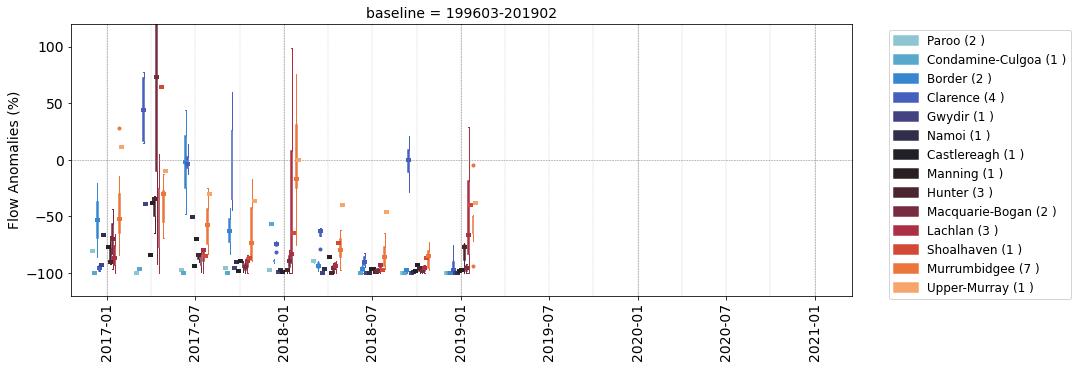

In [14]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/HRS_data/'
fig_dir = 'figures/drought_2017to2020/streamflow/'

stn_file = 'hrs_stations_gt905km2.csv'
df_stn = pd.read_csv(data_dir + stn_file)
# df_stn.head()
df_stn = df_stn.sort_values(by = "Catchment Area (km2)", ascending = False)

stn_Nos = df_stn['AWRC Statiion Number'].values

# All the basins in the file
# basin_list = np.unique(df_stn['Basin'].values)
# ordered basins - dry inland - north coastal - south coastal
basin_list = ['Paroo', 'Condamine-Culgoa', 'Border', 'Clarence', 'Gwydir', 'Namoi', 'Castlereagh', 'Manning', 'Hunter', 'Macquarie-Bogan', 'Lachlan', 'Shoalhaven', 'Murrumbidgee', 'Upper-Murray']

# baseline = slice('1981-03-01', '2020-05-31')  # adjusted the baseline for seasonal sum
# fig_suffix = 'ref_198103_202005'
# ref_title = 'baseline = 198103-201902'

baseline = slice('1996-03-01', '2020-05-31')  # adjusted the baseline for seasonal sum
fig_suffix = 'ref_199603_202005'
ref_title = 'baseline = 199603-201902'

# the timeslice of interest for monthly data
time_slice = slice('2016-12-01', '2020-11-30')  # adjusted the baseline for seasonal sum
vname = 'Flow'

# read in the streamflow data using the read_csv function by specifying a header
data_allBasins = []
for basin_sel in basin_list:
    stn_Nos_basin = df_stn['AWRC Statiion Number'].values[(df_stn['Basin'] == basin_sel) & (df_stn['Catchment Area (km2)']>905)]

    # list containing data for all stations
    list_ds = []

    # some check arrays
    list_count_nan = []
    list_start_date = []

    for iStn in range(len(stn_Nos_basin)):
        test_file = data_dir + str(stn_Nos_basin[iStn]) + '_daily_ts.csv'
        df_test = pd.read_csv(test_file, header = 26)

        # get dates in format datetime64
        date_array = pd.date_range(df_test['Date'][0], periods=len(df_test), freq="D")
        df_test['Date'] = date_array
        list_start_date.append(df_test['Date'][0])

        df_test = df_test.set_index(['Date'])
        # print(df_test['Date'].values[-1])  # to check that the timeseries all end consistently on 28 Feb 2022

        list_count_nan.append(sum(np.isnan(df_test['Flow (ML)'].values)))
        da_test = df_test.to_xarray().rename({'Flow (ML)': 'Flow'})
        
        # The record at some gauges starts mid-year at a year later than 1981, so the data needs to be sliced to avoid incorrect monthly totals
        if da_test['Date.year'][0].values > 1981:
            start_year = da_test['Date.year'][0].values
            da_test = da_test.sel(Date = slice(str(start_year+1)+'-01-01',None))
        list_ds.append(da_test)

    # create an xarray data array containing the data at all the stations
    ds_flow = xr.concat(list_ds, dim = 'station').assign_coords({'station': stn_Nos_basin}).rename({'Date': 'time'})
    ds_flow['Flow'] = ds_flow['Flow'].assign_attrs({'units': 'ML'})
    ds_flow = ds_flow.assign_attrs({'Source': 'http://www.bom.gov.au/water/hrs/'})
    
    print('Basin = ' + basin_sel)
    print(list_count_nan)
    print(list_start_date)
    print('------------------------------------------------')
    
    da_flow_seas = ds_flow[vname].resample(time = "QS-DEC").sum()
    # the monthly climatology from long-term data
    # the monthly anomalies during the drought period
    da_flow_lt_seasClim = da_flow_seas.sel(time = baseline).groupby('time.season').mean('time')
    da_flow_seasSel = da_flow_seas.sel(time = time_slice)
    seasArray = da_flow_seasSel['time.season'].values
    da_seasClim_for_diff = da_flow_lt_seasClim.sel(season = seasArray).rename({'season':'time'}).assign_coords({'time':da_flow_seasSel.time.values})
    da_for_plot = ((da_flow_seasSel - da_seasClim_for_diff)/da_seasClim_for_diff*100).assign_attrs({'units': '%'})
    
    # percentage diff during low flows may not mean anything
    da_flow_lt_seasClim_wnan = da_flow_lt_seasClim.where(da_flow_lt_seasClim > 10000)
    da_seasClim_for_diff_wnan = da_flow_lt_seasClim_wnan.sel(season = seasArray).rename({'season':'time'}).assign_coords({'time':da_flow_seasSel.time.values})
    da_for_plot_wnan = ((da_flow_seasSel - da_seasClim_for_diff_wnan)/da_seasClim_for_diff_wnan*100).assign_attrs({'units': '%'})
    
    data_allBasins.append(da_for_plot)
    

xx = data_allBasins[0].time.values + np.timedelta64(45, 'D')
str_time = [x.astype('datetime64[M]').astype('str') for x in xx]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-01', freq='QS-DEC', periods=4*4+1).to_numpy() + np.timedelta64(45, 'D')#.astype(float)
str_time_longer = [x.astype('datetime64[M]').astype('str') for x in seas_breaks]
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

# for xline in seas_breaks:
#     plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
# for xline in year_breaks:
#     plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

widthSel = 0.02

tick_locs_x = np.arange(len(da_for_plot[0].time.values))

x1 = tick_locs_x - 0.325
x2 = tick_locs_x - 0.275
x3 = tick_locs_x - 0.225
x4 = tick_locs_x - 0.175
x5 = tick_locs_x - 0.125
x6 = tick_locs_x - 0.075
x7 = tick_locs_x - 0.025
x8 = tick_locs_x + 0.025
x9 = tick_locs_x + 0.075
x10 = tick_locs_x + 0.125
x11 = tick_locs_x + 0.175
x12 = tick_locs_x + 0.225
x13 = tick_locs_x + 0.275
x14 = tick_locs_x + 0.325

data_x_list = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14]

bp_leg = []
col_sel = sns.color_palette("icefire", len(basin_list))

labels = [x + ' (' + str(len(y.station)) + ' )' for (x,y) in zip(basin_list, data_allBasins)]
for x, y, color, group in zip(data_x_list, data_allBasins, col_sel, labels):
    bp = plt.boxplot(y.values, positions=x, sym='.', widths=widthSel, patch_artist=True) #, notch = True)
    myfuncs.set_box_color(bp, color)
    bp_leg.append(bp["boxes"][0])  

plt.legend(bp_leg, labels, bbox_to_anchor=(1.04,1), loc="upper left")

for p in [0]:
    ax.axhline(y=p, linestyle='--', color = 'gray', linewidth=0.5)

tick_locs_x_longer = np.arange(len(seas_breaks))
for p in tick_locs_x_longer:  # season_breaks
    ax.axvline(x=p, linestyle='--', color = 'gray', linewidth=0.2)
for p in tick_locs_x_longer[::4]:  # year breaks
    plt.axvline(x=p, color = 'grey', linestyle = '--', linewidth = 0.5)

ax.set_xticks(tick_locs_x_longer[::2], rotation = 90) 
ax.set_xticklabels(str_time_longer[::2], rotation = 90)

plt.ylabel('Flow Anomalies (%)')
plt.title(ref_title)
ax.set_ylim((-120, 120))

fig.savefig(fig_dir + 'Q_anom_from_seasClim_largeCatchArea_allBasin_wnan_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'Q_anom_from_seasClim_largeCatchArea_allBasin_wnan_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')

In [13]:
str_time_longer[::4]

['2017-01', '2018-01', '2019-01', '2020-01', '2021-01']

In [30]:
nStations_allBasins = [len(x.station) for x in data_allBasins]
mean_allBasins = [np.round(x.mean('station').values,1) for x in data_allBasins]
median_allBasins = [np.round(x.median('station').values,1) for x in data_allBasins]
q25_allBasins = [np.round(x.quantile(q=0.25, dim = 'station').values,1) for x in data_allBasins]
q75_allBasins = [np.round(x.quantile(q=0.75, dim = 'station').values,1) for x in data_allBasins]

fname_list = ['mean', 'median', 'q25', 'q75']
data_list = [mean_allBasins, median_allBasins, q25_allBasins, q75_allBasins]

for fname, data in zip(fname_list, data_list):
    df_temp = pd.DataFrame(dict(zip(basin_list, data)))
    df_temp['time'] = data_allBasins[0].time.values
    df_temp = df_temp.set_index('time')
    out_file = '/g/data/w97/ad9701/drought_2017to2020/anomalies_csv/seas_streamflow_' + fname + '_perc_anomalies.csv'
    df_temp.to_csv(out_file)

In [29]:
df_median

,Paroo,Condamine-Culgoa,Border,Clarence,Gwydir,Namoi,Castlereagh,Manning,Hunter,Macquarie-Bogan,Lachlan,Shoalhaven,Murrumbidgee,Upper-Murray
time,,,,,,,,,,,,,,
2016-12-01,-80.7,-100.0,-53.1,-96.0,-93.3,-66.6,-97.1,-76.7,-90.4,-70.0,-86.6,-80.6,-52.6,10.9
2017-03-01,-100.0,-96.7,357.4,44.0,-38.9,90.8,-84.3,-38.0,-35.1,72.8,-55.0,64.1,-30.2,-9.5
2017-06-01,-97.2,-100.0,-2.1,-3.7,-82.7,-50.9,-94.1,-69.8,-84.2,-88.5,-79.2,-85.4,-57.7,-29.9
2017-09-01,-95.9,-100.0,-62.6,-8.8,-95.9,-90.1,-97.9,-89.4,-91.2,-94.9,-89.0,-86.6,-73.5,-36.6
2017-12-01,-97.4,-56.3,-89.5,-74.1,-98.7,-97.1,-99.0,-97.8,-97.4,-89.8,-83.1,-64.5,-16.9,-0.6
2018-03-01,-89.7,-70.9,-93.6,-63.2,-100.0,-96.4,-96.8,-86.1,-100.0,-95.8,-93.6,-73.4,-79.2,-40.2
2018-06-01,-100.0,-100.0,-96.2,-90.0,-100.0,-99.6,-96.6,-96.6,-99.1,-97.9,-93.2,-96.9,-86.0,-46.3
2018-09-01,-100.0,-100.0,-97.8,-0.4,-100.0,-98.8,-98.5,-93.1,-95.9,-97.9,-95.9,-86.5,-85.3,-51.9
2018-12-01,-100.0,-100.0,-100.0,-97.3,-100.0,-99.9,-97.9,-97.1,-76.8,-95.9,-66.2,-39.5,-52.1,-38.1


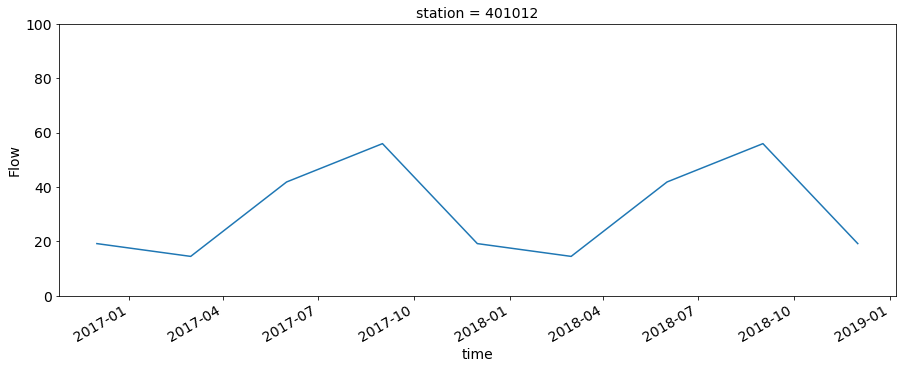

In [28]:
(da_seasClim_for_diff/3000).plot(size=5, aspect=3, ylim=(0, 100))

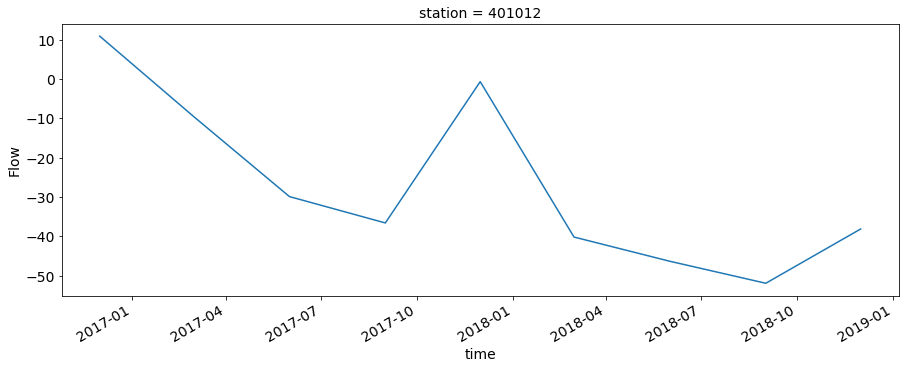

In [31]:
((da_flow_seasSel-da_seasClim_for_diff)/da_seasClim_for_diff*100).plot(size=5, aspect=3) #, ylim=(0, 100))

### Monthly Q

In [18]:
da_flow_mon_GL

<xarray.DataArray 'Flow' (station: 30, time: 27)>
array([[1.33604640e+01, 1.06402464e+01, 8.82653760e+00, 1.49472000e-02,
        0.00000000e+00, 0.00000000e+00, 2.18764800e-01, 2.32416000e-02,
        0.00000000e+00, 0.00000000e+00, 2.94624000e-02, 4.53081600e-01,
        4.06218240e+00, 1.90080000e-03, 0.00000000e+00, 6.12766080e+00,
        2.20579200e-01, 3.08534400e+00, 5.35680000e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.81664000e-02, 0.00000000e+00],
       [2.27880000e+01, 1.76245632e+01, 6.94716480e+00, 3.99168000e-02,
        0.00000000e+00, 0.00000000e+00, 1.11179520e+00, 6.91200000e-04,
        0.00000000e+00, 0.00000000e+00, 1.11421440e+00, 1.22342400e-01,
        7.03857600e+00, 0.00000000e+00, 0.00000000e+00, 1.03054464e+01,
        3.59320320e+00, 1.48910400e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.08059344e+01, 4.66013049e+01, 2.63232754e+01, 1.13055378e+03,
        7.13421442e+02, 8.42447283e+01, 2.02765088e+02, 9.12512623e+01,
        3.64120484e+01, 1.57279382e+01, 1.14664581e+02, 7.50100207e+01,
        1.35260735e+02, 1.40741443e+02, 6.91642728e+01, 3.05306691e+02,
        6.62933685e+01, 3.28300709e+01, 2.40041225e+01, 2.42317005e+01,
        1.27193985e+01, 1.50952299e+01, 3.08238334e+02, 4.87349566e+01,
...
        3.90257880e-01, 6.62755854e-01, 4.86072798e-01, 5.45859925e-01,
        1.52249820e+00, 5.13374435e-01, 3.62092268e-01, 2.93492587e-01,
        2.97147205e+00, 1.70030442e-01, 5.50352600e-02, 2.40185279e-02,
        2.44505158e-02, 4.85554413e-02, 8.18185105e-02, 1.35471409e-01,
        1.66833732e-01, 2.03725499e-01, 6.97228490e-02, 2.46492303e-01,
        3.02218743e-01, 2.70770023e-01, 1.46746294e+00],
       [1.14465932e+00, 5.26795584e-01, 1.07052604e-01, 3.06382998e-01,
        4.12225969e-01, 3.73517682e-01, 5.55221982e-01, 6.28318433e-01,
        2.98001963e-01, 6.92947447e-02, 1.53796316e-02, 7.86262065e-03,
        3.02408487e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.72804850e-04, 0.00000000e+00, 0.00000000e+00, 1.39094321e-02,
        9.76347400e-03, 0.00000000e+00, 0.00000000e+00],
       [1.53152319e+01, 8.67619788e+00, 4.08797852e+00, 4.29058038e+00,
        5.82508428e+00, 7.83131789e+00, 6.06734254e+00, 8.15522167e+00,
        2.73285287e+01, 1.85331888e+01, 1.05897271e+01, 1.09389453e+01,
        3.26987307e+01, 7.31086006e+00, 4.00693778e+00, 3.03574481e+00,
        2.83910437e+00, 3.42868010e+00, 5.79208048e+00, 6.39280148e+00,
        1.21309700e+01, 1.09674565e+01, 5.95347079e+00, 6.60533904e+00,
        1.15378520e+01, 3.39895940e+00, 1.90834537e+00]])
Coordinates:
  * station  (station) object '424002' '424201A' '204007' ... '210052' '410024'
  * time     (time) datetime64[ns] 2016-12-31 2017-01-31 ... 2019-02-28
Attributes:
    units:    GL

In [19]:
col_sel

[(0.65342679, 0.84218728, 0.83611512),
 (0.56349779, 0.78357215, 0.81834861),
 (0.46982587, 0.72703075, 0.80747097),
 (0.36442578, 0.66328229, 0.80417474),
 (0.28759072, 0.60300319, 0.80616055),
 (0.22921445, 0.53918506, 0.81267292),
 (0.21842857, 0.46909168, 0.81351614),
 (0.2644736, 0.38651212, 0.76524809),
 (0.28816354, 0.32200604, 0.67684067),
 (0.27665361, 0.27465357, 0.55667809),
 (0.24433654, 0.23539226, 0.4397245),
 (0.20101757, 0.19411573, 0.32529173),
 (0.16448691, 0.16091728, 0.24075373),
 (0.13667798, 0.13446606, 0.17493774),
 (0.12232067, 0.11984278, 0.13124644),
 (0.13855459, 0.11606618, 0.11910584),
 (0.18468769, 0.12114722, 0.13306426),
 (0.24676041, 0.13462172, 0.15870321),
 (0.32111555, 0.15103351, 0.19119629),
 (0.41537995, 0.16745325, 0.2282297),
 (0.50623876, 0.17687777, 0.255096),
 (0.60127582, 0.18175888, 0.26858488),
 (0.69281185, 0.19535326, 0.25887063),
 (0.78115441, 0.23998404, 0.23013825),
 (0.84322168, 0.30491136, 0.20766435),
 (0.89203964, 0.38273475, 0.20013431),
 (0.92491786, 0.4705936, 0.23308207),
 (0.94792955, 0.57219822, 0.33184256),
 (0.96591497, 0.65899621, 0.44380444),
 (0.9829001, 0.74474445, 0.5597019)]

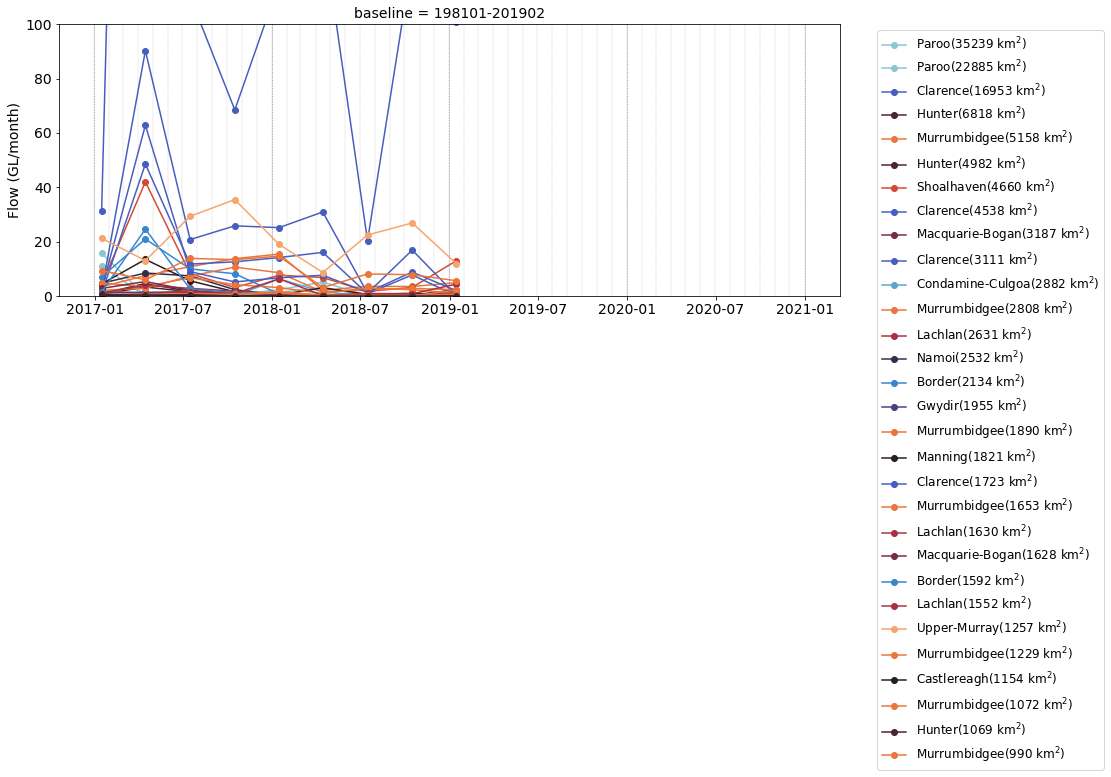

In [11]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/HRS_data/'
fig_dir = 'figures/drought_2017to2020/streamflow/'

stn_file = 'hrs_stations_gt905km2.csv'
df_stn = pd.read_csv(data_dir + stn_file)
# df_stn.head()
df_stn = df_stn.sort_values(by = "Catchment Area (km2)", ascending = False)

stn_Nos = df_stn['AWRC Statiion Number'].values

# All the basins in the file
#basin_list = np.unique(df_stn['Basin'].values)
basin_list = ['Paroo', 'Condamine-Culgoa', 'Border', 'Clarence', 'Gwydir', 'Namoi', 'Castlereagh', 'Manning', 'Hunter', 'Macquarie-Bogan', 'Lachlan', 'Shoalhaven', 'Murrumbidgee', 'Upper-Murray']

basin_colors = sns.color_palette("icefire", len(basin_list))
basin_colors_dict = dict(zip(basin_list, basin_colors))

baseline = slice('1981-01-01', '2020-05-31')
fig_suffix = 'ref_198101_202005'
ref_title = 'baseline = 198101-201902'

# baseline = slice('1996-01-01', '2020-05-31')
# fig_suffix = 'ref_199601_202005'
# ref_title = 'baseline = 199601-201902'

# the timeslice of interest for monthly data
time_slice = slice('2016-12-01', '2020-12-31')
vname = 'Flow'

# read in the streamflow data using the read_csv function by specifying a header
#for basin_sel in basin_list:
    
stn_Nos_basin = df_stn['AWRC Statiion Number'].values#[df_stn['Basin'] == basin_sel]

# list containing data for all stations
list_ds = []

# some check arrays
list_count_nan = []
list_start_date = []

for iStn in range(len(stn_Nos_basin)):
    test_file = data_dir + str(stn_Nos_basin[iStn]) + '_daily_ts.csv'
    df_test = pd.read_csv(test_file, header = 26)

    # get dates in format datetime64
    date_array = pd.date_range(df_test['Date'][0], periods=len(df_test), freq="D")
    df_test['Date'] = date_array
    list_start_date.append(df_test['Date'][0])

    df_test = df_test.set_index(['Date'])
    # print(df_test['Date'].values[-1])  # to check that the timeseries all end consistently on 28 Feb 2022

    list_count_nan.append(sum(np.isnan(df_test['Flow (ML)'].values)))
    da_test = df_test.to_xarray().rename({'Flow (ML)': 'Flow'})

    # The record at some gauges starts mid-year at a year later than 1981, so the data needs to be sliced to avoid incorrect monthly totals
    if da_test['Date.year'][0].values > 1981:
        start_year = da_test['Date.year'][0].values
        da_test = da_test.sel(Date = slice(str(start_year+1)+'-01-01',None))
    list_ds.append(da_test)

# create an xarray data array containing the data at all the stations
ds_flow = xr.concat(list_ds, dim = 'station').assign_coords({'station': stn_Nos_basin}).rename({'Date': 'time'})
ds_flow['Flow'] = ds_flow['Flow'].assign_attrs({'units': 'ML'})
ds_flow = ds_flow.assign_attrs({'Source': 'http://www.bom.gov.au/water/hrs/'})

# print('Basin = ' + basin_sel)
# print(list_count_nan)
# print(list_start_date)
# print('------------------------------------------------')

da_flow_mon = ds_flow[vname].resample(time = '1M').sum()
# the monthly climatology from long-term data
# the monthly anomalies during the drought period
da_flow_lt_monClim = da_flow_mon.sel(time = baseline).groupby('time.month').mean('time')
da_flow_monAnom = ((da_flow_mon.sel(time = time_slice).groupby('time.month') - da_flow_lt_monClim)/1000).assign_attrs({'units': 'GL'})
da_flow_mon_GL = (da_flow_mon.sel(time = time_slice)/1000).assign_attrs({'units': 'GL'})

###################################
# MONTHLY PLOT (may not be completely relevan, but will save in case
###################################

nStations = len(da_flow_monAnom.station.values)
# col_sel = sns.color_palette()[0:nStations]
# col_sel = sns.color_palette("icefire", nStations)


data_list = [da_flow_mon_GL.sel(station = s) for s in da_flow_mon_GL.station.values]
data_names = [str(x) + '(' + str(round(y)) + ' km$^2$)' for (x,y) in zip(df_stn['Basin'].values, df_stn['Catchment Area (km2)'].values)]
#data_names = [str(x) + '(' + str(round(y)) + ' km$^2$)' for (x,y) in zip(da_flow_mon_GL.station.values, df_stn['Catchment Area (km2)'].values)]
col_sel = [basin_colors_dict[x] for x in df_stn['Basin'].values]

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
for da, color, label in zip(data_list, col_sel, data_names):       
    #plt.plot(da.time.values, da.values, marker='o', color=color, label=label)

    xx = da.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
    array_time = [x.astype('datetime64[D]') for x in xx]
    array_val = da.resample(time="QS-DEC").mean().values
    #plt.bar(array_time, array_val, width=85, edgecolor='white', color=color, alpha=0.2)
    plt.plot(array_time, array_val, marker='o', color=color, label=label)

plt.xlabel('')
plt.ylabel('Flow (GL/month)')
plt.title(ref_title)
#plt.title(basin_sel + ' (' + ref_title + ')')
plt.ylim((0, 100))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
fig.savefig(fig_dir + 'Q_seasFlow_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'Q_SeasFlow_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')

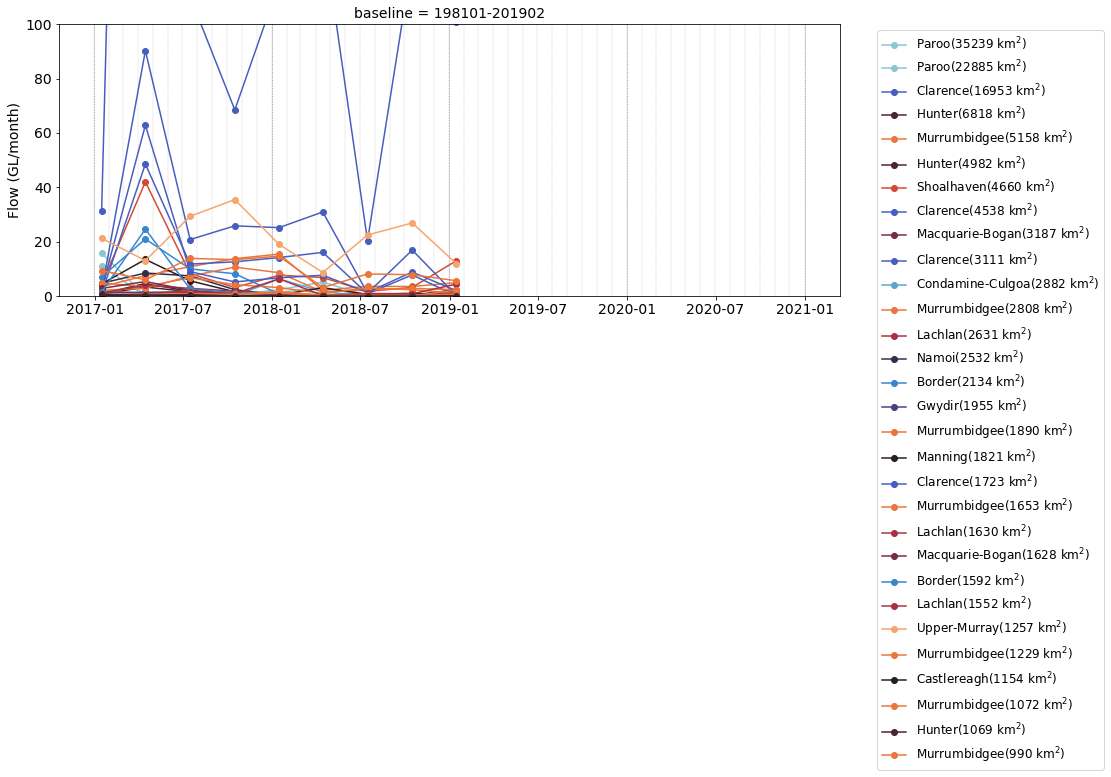

In [13]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/HRS_data/'
fig_dir = 'figures/drought_2017to2020/streamflow/'

stn_file = 'hrs_stations_gt905km2.csv'
df_stn = pd.read_csv(data_dir + stn_file)
# df_stn.head()
df_stn = df_stn.sort_values(by = "Catchment Area (km2)", ascending = False)

# subset df_stn
# df_stn = df_stn[df_stn['Catchment Area (km2)']>5000]

stn_Nos = df_stn['AWRC Statiion Number'].values

# All the basins in the file
# basin_list = np.unique(df_stn['Basin'].values)
basin_list = ['Paroo', 'Condamine-Culgoa', 'Border', 'Clarence', 'Gwydir', 'Namoi', 'Castlereagh', 'Manning', 'Hunter', 'Macquarie-Bogan', 'Lachlan', 'Shoalhaven', 'Murrumbidgee', 'Upper-Murray']

basin_colors = sns.color_palette("icefire", len(basin_list))
basin_colors_dict = dict(zip(basin_list, basin_colors))

baseline = slice('1981-01-01', '2020-05-31')
fig_suffix = 'ref_198101_202005'
ref_title = 'baseline = 198101-201902'

# baseline = slice('1996-01-01', '2020-05-31')
# fig_suffix = 'ref_199601_202005'
# ref_title = 'baseline = 199601-201902'

# the timeslice of interest for monthly data
time_slice = slice('2016-12-01', '2020-12-31')
vname = 'Flow'

# read in the streamflow data using the read_csv function by specifying a header
#for basin_sel in basin_list:
    
stn_Nos_basin = df_stn['AWRC Statiion Number'].values#[df_stn['Basin'] == basin_sel]

# list containing data for all stations
list_ds = []

# some check arrays
list_count_nan = []
list_start_date = []

for iStn in range(len(stn_Nos_basin)):
    test_file = data_dir + str(stn_Nos_basin[iStn]) + '_daily_ts.csv'
    df_test = pd.read_csv(test_file, header = 26)

    # get dates in format datetime64
    date_array = pd.date_range(df_test['Date'][0], periods=len(df_test), freq="D")
    df_test['Date'] = date_array
    list_start_date.append(df_test['Date'][0])

    df_test = df_test.set_index(['Date'])
    # print(df_test['Date'].values[-1])  # to check that the timeseries all end consistently on 28 Feb 2022

    list_count_nan.append(sum(np.isnan(df_test['Flow (ML)'].values)))
    da_test = df_test.to_xarray().rename({'Flow (ML)': 'Flow'})

    # The record at some gauges starts mid-year at a year later than 1981, so the data needs to be sliced to avoid incorrect monthly totals
    if da_test['Date.year'][0].values > 1981:
        start_year = da_test['Date.year'][0].values
        da_test = da_test.sel(Date = slice(str(start_year+1)+'-01-01',None))
    list_ds.append(da_test)

# create an xarray data array containing the data at all the stations
ds_flow = xr.concat(list_ds, dim = 'station').assign_coords({'station': stn_Nos_basin}).rename({'Date': 'time'})
ds_flow['Flow'] = ds_flow['Flow'].assign_attrs({'units': 'ML'})
ds_flow = ds_flow.assign_attrs({'Source': 'http://www.bom.gov.au/water/hrs/'})

# print('Basin = ' + basin_sel)
# print(list_count_nan)
# print(list_start_date)
# print('------------------------------------------------')

da_flow_mon = ds_flow[vname].resample(time = '1M').sum()
# the monthly climatology from long-term data
# the monthly anomalies during the drought period
da_flow_lt_monClim = da_flow_mon.sel(time = baseline).groupby('time.month').mean('time')
da_flow_monAnom = ((da_flow_mon.sel(time = time_slice).groupby('time.month') - da_flow_lt_monClim)/1000).assign_attrs({'units': 'GL'})
da_flow_mon_GL = (da_flow_mon.sel(time = time_slice)/1000).assign_attrs({'units': 'GL'})

###################################
# MONTHLY PLOT (may not be completely relevan, but will save in case
###################################

nStations = len(da_flow_monAnom.station.values)
# col_sel = sns.color_palette()[0:nStations]
col_sel = sns.color_palette("icefire", nStations)

# data_list = [da_flow_mon_GL.sel(station = s) for s in da_flow_mon_GL.station.values]
# data_names = [str(x) + '(' + str(round(y)) + ' km$^2$)' for (x,y) in zip(da_flow_mon_GL.station.values, df_stn['Catchment Area (km2)'].values)]

data_list = [da_flow_mon_GL.sel(station = s) for s in da_flow_mon_GL.station.values]
data_names = [str(x) + '(' + str(round(y)) + ' km$^2$)' for (x,y) in zip(df_stn['Basin'].values, df_stn['Catchment Area (km2)'].values)]
#data_names = [str(x) + '(' + str(round(y)) + ' km$^2$)' for (x,y) in zip(da_flow_mon_GL.station.values, df_stn['Catchment Area (km2)'].values)]
col_sel = [basin_colors_dict[x] for x in df_stn['Basin'].values]

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
for da, color, label in zip(data_list, col_sel, data_names):       
    # plt.plot(da.time.values, da.values, marker='o', color=color, label=label)

    xx = da.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
    array_time = [x.astype('datetime64[D]') for x in xx]
    array_val = da.resample(time="QS-DEC").mean().values
    #plt.bar(array_time, array_val, width=85, edgecolor='white', color=color, alpha=0.2)
    plt.plot(array_time, array_val, marker='o', color=color, label=label)

plt.xlabel('')
plt.ylabel('Flow (GL/month)')
plt.title(ref_title)
#plt.title(basin_sel + ' (' + ref_title + ')')
plt.ylim((0, 100))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
fig.savefig(fig_dir + 'Q_seasFlow_test_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'Q_seasFlow_test_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')

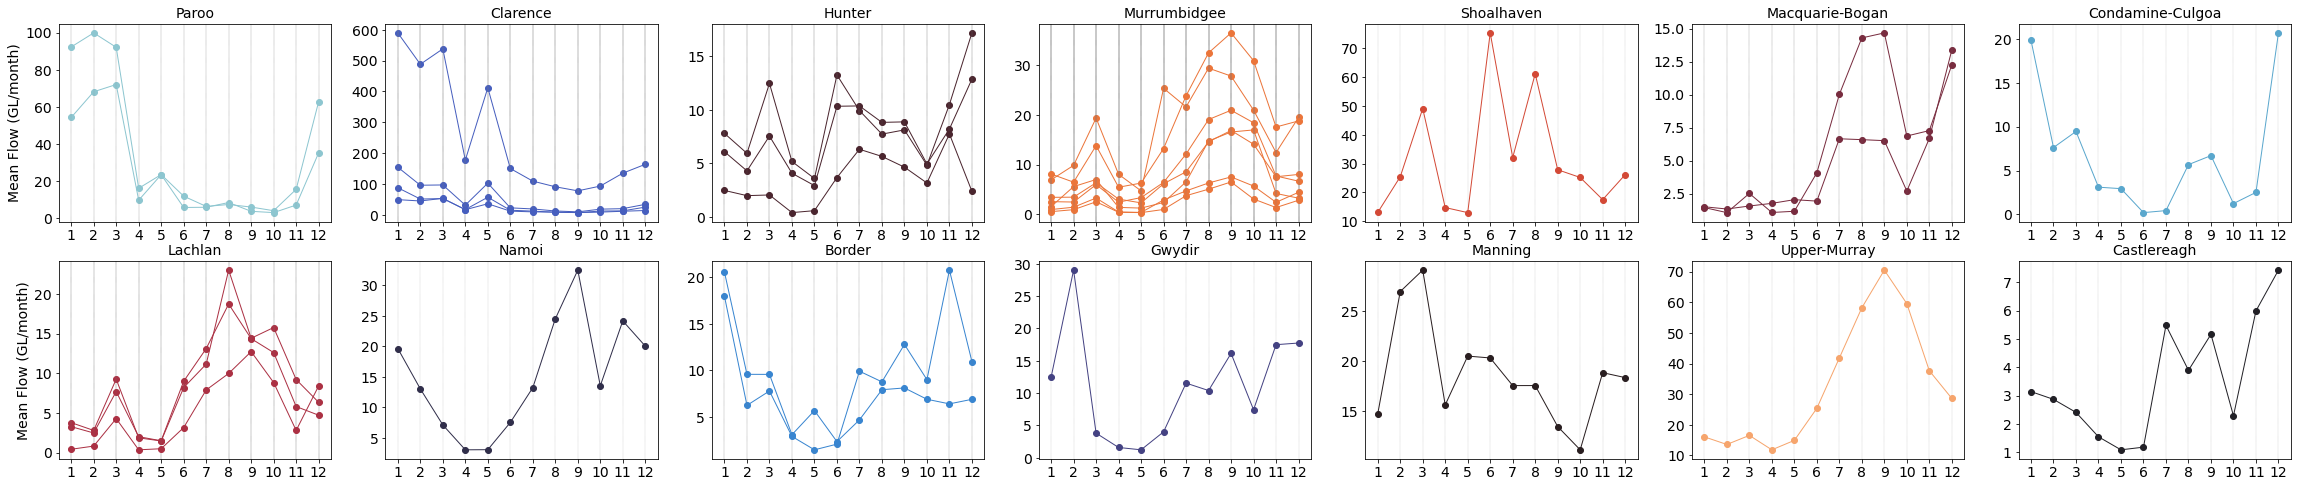

In [15]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/HRS_data/'
fig_dir = 'figures/drought_2017to2020/streamflow/'

stn_file = 'hrs_stations_gt905km2.csv'
df_stn = pd.read_csv(data_dir + stn_file)
# df_stn.head()
df_stn = df_stn.sort_values(by = "Catchment Area (km2)", ascending = False)

# subset df_stn
# df_stn = df_stn[df_stn['Catchment Area (km2)']>5000]

stn_Nos = df_stn['AWRC Statiion Number'].values

# All the basins in the file
# basin_list = np.unique(df_stn['Basin'].values)
basin_list = ['Paroo', 'Condamine-Culgoa', 'Border', 'Clarence', 'Gwydir', 'Namoi', 'Castlereagh', 'Manning', 'Hunter', 'Macquarie-Bogan', 'Lachlan', 'Shoalhaven', 'Murrumbidgee', 'Upper-Murray']

basin_colors = sns.color_palette("icefire", len(basin_list))
basin_colors_dict = dict(zip(basin_list, basin_colors))

# baseline = slice('1981-01-01', '2020-05-31')
# fig_suffix = 'ref_198101_202005'
# ref_title = 'baseline = 198101-201902'

baseline = slice('1996-01-01', '2020-05-31')
fig_suffix = 'ref_199601_202005'
ref_title = 'baseline = 199601-201902'

# the timeslice of interest for monthly data
time_slice = slice('2016-12-01', '2020-12-31')
vname = 'Flow'

# read in the streamflow data using the read_csv function by specifying a header
# for basin_sel in basin_list:

stn_Nos_basin = df_stn['AWRC Statiion Number'].values
#[df_stn['Basin'] == basin_sel]

# list containing data for all stations
list_ds = []

# some check arrays
list_count_nan = []
list_start_date = []

for iStn in range(len(stn_Nos_basin)):
    test_file = data_dir + str(stn_Nos_basin[iStn]) + '_daily_ts.csv'
    df_test = pd.read_csv(test_file, header = 26)

    # get dates in format datetime64
    date_array = pd.date_range(df_test['Date'][0], periods=len(df_test), freq="D")
    df_test['Date'] = date_array
    list_start_date.append(df_test['Date'][0])

    df_test = df_test.set_index(['Date'])
    # print(df_test['Date'].values[-1])  # to check that the timeseries all end consistently on 28 Feb 2022

    list_count_nan.append(sum(np.isnan(df_test['Flow (ML)'].values)))
    da_test = df_test.to_xarray().rename({'Flow (ML)': 'Flow'})

    # The record at some gauges starts mid-year at a year later than 1981, so the data needs to be sliced to avoid incorrect monthly totals
    if da_test['Date.year'][0].values > 1981:
        start_year = da_test['Date.year'][0].values
        da_test = da_test.sel(Date = slice(str(start_year+1)+'-01-01',None))
    list_ds.append(da_test)

# create an xarray data array containing the data at all the stations
ds_flow = xr.concat(list_ds, dim = 'station').assign_coords({'station': stn_Nos_basin}).rename({'Date': 'time'})
ds_flow['Flow'] = ds_flow['Flow'].assign_attrs({'units': 'ML'})
ds_flow = ds_flow.assign_attrs({'Source': 'http://www.bom.gov.au/water/hrs/'})

# print('Basin = ' + basin_sel)
# print(list_count_nan)
# print(list_start_date)
# print('------------------------------------------------')

da_flow_mon = ds_flow[vname].resample(time = '1M').sum()
# the monthly climatology from long-term data
da_flow_lt_monClim = (da_flow_mon.sel(time = baseline).groupby('time.month').mean('time')/1000).assign_attrs({'units': 'GL'})

###################################
# MONTHLY CLIMATOLOGY PLOT (may not be completely relevant, but will save in case
###################################
nStations = len(da_flow_lt_monClim.station.values)
# col_sel = sns.color_palette()[0:nStations]
col_sel = sns.color_palette("icefire", nStations)

#data_names = [str(x) + '(' + str(round(y)) + ' km$^2$)' for (x,y) in zip(da_flow_monAnom.station.values, df_stn['Catchment Area (km2)'].values)]
data_list = [da_flow_lt_monClim.sel(station = s) for s in da_flow_lt_monClim.station.values]
#data_names = [str(x) + '(' + str(round(y)) + ' km$^2$)' for (x,y) in zip(df_stn['Basin'].values, df_stn['Catchment Area (km2)'].values)]
#data_names = [str(x) + '(' + str(round(y)) + ' km$^2$)' for (x,y) in zip(da_flow_mon_GL.station.values, df_stn['Catchment Area (km2)'].values)]
data_names_unique = list(pd.unique(df_stn['Basin'].values))
data_names = df_stn['Basin'].values
col_sel = [basin_colors_dict[x] for x in df_stn['Basin'].values]

fig, ax = plt.subplots(nrows=2,ncols=7, figsize=(40,8)) #width, height
ax = ax.flatten()


for da, color, label in zip(data_list, col_sel, data_names):  
    ax_sel = data_names_unique.index(label)
    for xline in range(1, 13):
        ax[ax_sel].axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
    
    ax[ax_sel].plot(da.month.values, da.values, color=color, marker="o", linewidth=1, label=label)
    #ax[ax_sel].xlabel('month')
    ax[ax_sel].set_xlabel('')
    if (ax_sel == 0) | (ax_sel == 7):
        ax[ax_sel].set_ylabel('Mean Flow (GL/month)')
    ax[ax_sel].set_title(label)
    ax[ax_sel].set_xticks(range(1,13))
    # plt.ylim((0, 200))
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
fig.savefig(fig_dir + 'Q_monClim_allBasin_' + fig_suffix + '.png', bbox_inches='tight', dpi = 600)
fig.savefig(fig_dir + 'Q_monClim_allBasin_' + fig_suffix + '.pdf', bbox_inches='tight', format = 'pdf')

In [44]:
x1

array(['2016-12-23T00:00:00.000000000', '2017-03-23T00:00:00.000000000',
       '2017-06-23T00:00:00.000000000', '2017-09-23T00:00:00.000000000',
       '2017-12-23T00:00:00.000000000', '2018-03-23T00:00:00.000000000',
       '2018-06-23T00:00:00.000000000', '2018-09-23T00:00:00.000000000',
       '2018-12-23T00:00:00.000000000'], dtype='datetime64[ns]')

In [45]:
x2

array(['2017-02-06T00:00:00.000000000', '2017-05-07T00:00:00.000000000',
       '2017-08-07T00:00:00.000000000', '2017-11-07T00:00:00.000000000',
       '2018-02-06T00:00:00.000000000', '2018-05-07T00:00:00.000000000',
       '2018-08-07T00:00:00.000000000', '2018-11-07T00:00:00.000000000',
       '2019-02-06T00:00:00.000000000'], dtype='datetime64[ns]')

In [42]:
data_allBasins[0].time.values

array(['2016-12-01T00:00:00.000000000', '2017-03-01T00:00:00.000000000',
       '2017-06-01T00:00:00.000000000', '2017-09-01T00:00:00.000000000',
       '2017-12-01T00:00:00.000000000', '2018-03-01T00:00:00.000000000',
       '2018-06-01T00:00:00.000000000', '2018-09-01T00:00:00.000000000',
       '2018-12-01T00:00:00.000000000'], dtype='datetime64[ns]')

{'whiskers': [<matplotlib.lines.Line2D at 0x7f1ab60bcf40>,
 'caps': [<matplotlib.lines.Line2D at 0x7f1ab609a550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f1ab60bcc70>,
 'medians': [<matplotlib.lines.Line2D at 0x7f1ab609aaf0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f1ab609adc0>,
 'means': []}

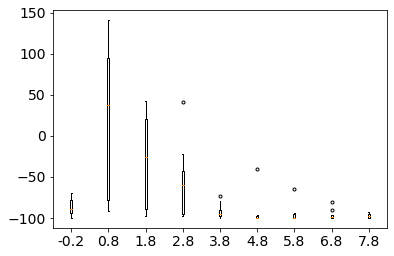

In [41]:
plt.boxplot(data_allBasins[0].values, positions=x1, sym='.', widths=0.05, patch_artist=False) #, notch = True)

In [37]:
x1

array([-0.2,  0.8,  1.8,  2.8,  3.8,  4.8,  5.8,  6.8,  7.8])

In [40]:
data_allBasins[0].values

array([[ -92.90507212,  -74.74046598,  -88.00300458,  -95.18529855,
         -98.61916777, -100.        , -100.        , -100.        ,
        -100.        ],
       [ -96.11204187,  -88.82520322,  -97.21456307,  -98.12312218,
         -99.76612624, -100.        ,  -99.9983901 , -100.        ,
        -100.        ],
       [ -90.39859394,   77.04915337,   13.9543962 ,   40.73343432,
         -96.58922075,  -96.87070476,  -95.30539987,  -98.11195594,
         -99.28942099],
       [ -69.17328307,  140.70421935,  -21.03698838,  -68.95076788,
         -72.70875843,  -97.55752226,  -94.61347211,  -90.15367463,
         -95.00853509],
       [ -73.19217874,   91.94813511,   42.23662262,  -22.09373295,
         -95.69693894,  -99.98297842, -100.        ,  -98.5467903 ,
         -92.45131561],
       [ -87.77802075,  100.9112755 ,   42.02617161,  -50.75012984,
         -94.71284821,  -99.96204208, -100.        , -100.        ,
        -100.        ],
       [ -99.9094718 ,  -91.12005025,  -

In [170]:
ds_flow[vname].resample(time = "QS-DEC").sum()

<xarray.DataArray 'Flow' (station: 19, time: 277)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.07032320e+04, 1.05130656e+04, 1.47502080e+04],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.63666215e+03, 8.34766852e+03, 6.99445023e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.92521719e+03, 6.91766323e+03, 3.16382417e+03],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 8.63702991e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.43328320e+03, 2.62336320e+03, 2.90805120e+03],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.75481431e+03, 2.51091730e+03]])
Coordinates:
  * station  (station) int64 410761 410033 410047 ... 410156 410730 411003
  * time     (time) datetime64[ns] 1949-12-01 1950-03-01 ... 2018-12-01

In [31]:
myfuncs.create_boxplots??

Signature:
myfuncs.create_boxplots(
    ax,
    obs_sets,
    prob_band,
    set_names,
    colors,
    title=None,
    xlabel='Model probability bins',
    ylabel='Observed proportion',
    ylim=(0, 1),
    add_legend=True,
    add_xlabel=True,
    add_ylabel=True,
)
Docstring: <no docstring>
Source:   
def create_boxplots(ax, obs_sets, prob_band, set_names, colors, title = None, xlabel = 'Model probability bins', ylabel = 'Observed proportion', ylim = (0,1), add_legend = True, add_xlabel = True, add_ylabel = True):

    tick_locs_x = np.arange(len(obs_sets[0]))
    x1 = tick_locs_x - 0.2
    x2 = tick_locs_x
    x3 = tick_locs_x + 0.2
    data_x_list = [x1, x2, x3]

    bp_leg = []
    for x, y, color, group in zip(data_x_list, obs_sets, colors, set_names):
        bp = ax.boxplot(y, positions=x, sym='.', widths=0.15, patch_artist=True) #, notch = True)
        set_box_color(bp, color)
        bp_leg.append(bp["boxes"][0])        

    for p in prob_band:
        ax.axhline(y=p, line

In [190]:
da_for_plot.plot.boxplot(x='time', size=5, aspect=2, label=da_flow_seas.station.values)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

AttributeError: '_PlotMethods' object has no attribute 'boxplot'

In [8]:
da_for_plot

<xarray.DataArray 'Flow' (station: 19, time: 9)>
array([[ -78.45167842,  -50.15187882,  -68.20635099,  -47.05571167,
          -3.06991825,  -86.23713568,  -89.48479227,  -86.49647423,
         -69.10889132],
       [ -65.1678604 ,  -30.88605098,  -41.39436812,  -26.76372492,
          44.7242661 ,  -64.30248003,  -82.33191596,  -80.80785206,
         -60.67710441],
       [  -1.90364723,  -24.29599859,  -67.79686139,  -78.20549954,
         -36.21410939,  -79.65749372,  -85.75663287,  -87.91562317,
         -78.3347352 ],
       [ -86.88216275,  -83.85307897,  -89.70886832,  -90.47737392,
         -40.24810382,  -91.17324396,  -97.01131608,  -98.23590493,
         -21.3983237 ],
       [ -65.3780263 ,  -63.83806504,  -85.67904874,  -91.83301276,
         -43.75411509,  -97.90465647,  -97.84648078,  -96.367411  ,
         -64.09646295],
       [ -28.03984982,  -37.47870965,  -54.52859352,  -58.39017815,
          12.8028045 ,  -67.58961272,  -73.38996614,  -75.56469621,
         -56.83028661],
       [ -78.48350809,  -63.57282795,  -66.73276986,  -72.07579682,
         -37.75352072,  -93.66604019,  -87.60795389,  -88.64907029,
...
           0.51591054,  -66.97512317,  -73.11155504,  -77.44305643,
         -72.00513701],
       [ -74.47547185,  -66.91067412,  -76.59044632,  -81.12245972,
         -57.91587082,  -96.36577655,  -94.87877096,  -97.4147826 ,
         -87.5407976 ],
       [ -90.24176328,  -75.97712983,  -81.92988731,  -84.72483733,
         -57.22882312,  -96.20001872,  -93.94863118,  -94.21803917,
         -89.56389626],
       [  10.86339514,   -7.74097067,  -52.67142742,  -61.22938191,
         -25.49664028,  -65.35313165,  -74.9105627 ,  -79.47961827,
         -74.59445351],
       [ -93.56405271, -100.        ,  -98.66533746,  -99.53456488,
         -72.69647872, -100.        , -100.        , -100.        ,
         -99.98358177],
       [ -62.52154979,  -54.23736273,  -60.4476153 ,  -63.5899123 ,
           0.59059557,  -80.48710878,  -78.34874416,  -82.01061781,
         -60.22043842],
       [ -91.5055349 ,  -76.49724361,  -97.25516898,  -84.9018779 ,
          66.79009179,  -99.42928563, -100.        ,   41.11742147,
         149.35581914]])
Coordinates:
  * station  (station) int64 410761 410033 410047 ... 410156 410730 411003
  * time     (time) datetime64[ns] 2016-12-01 2017-03-01 ... 2018-12-01
Attributes:
    units:    %

In [14]:
stn_subset = df_stn['AWRC Statiion Number'].values[(df_stn['Basin'] == basin_sel) & (df_stn['Catchment Area (km2)']>905)]

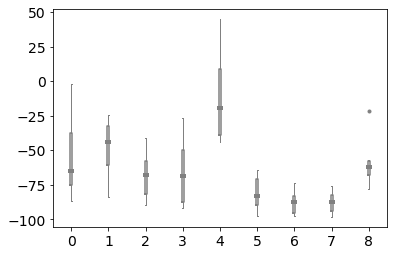

In [15]:
da_for_plot_subset = da_for_plot.sel(station = stn_subset)

tick_locs_x = np.arange(len(da_for_plot.time.values))
x1 = tick_locs_x - 0.2
x2 = tick_locs_x
x3 = tick_locs_x + 0.2
data_x_list = [x2]

bp_leg = []

color = 'grey'
# for x, y, color, group in zip(data_x_list, obs_sets, colors, set_names):
bp = plt.boxplot(da_for_plot_subset.values, positions=x2, sym='.', widths=0.05, patch_artist=False) #, notch = True)
myfuncs.set_box_color(bp, color)
bp_leg.append(bp["boxes"][0])

In [32]:
da_for_plot_subset

<xarray.DataArray 'Flow' (station: 6, time: 9)>
array([[-78.45167842, -50.15187882, -68.20635099, -47.05571167,
         -3.06991825, -86.23713568, -89.48479227, -86.49647423,
        -69.10889132],
       [-65.1678604 , -30.88605098, -41.39436812, -26.76372492,
         44.7242661 , -64.30248003, -82.33191596, -80.80785206,
        -60.67710441],
       [ -1.90364723, -24.29599859, -67.79686139, -78.20549954,
        -36.21410939, -79.65749372, -85.75663287, -87.91562317,
        -78.3347352 ],
       [-86.88216275, -83.85307897, -89.70886832, -90.47737392,
        -40.24810382, -91.17324396, -97.01131608, -98.23590493,
        -21.3983237 ],
       [-65.3780263 , -63.83806504, -85.67904874, -91.83301276,
        -43.75411509, -97.90465647, -97.84648078, -96.367411  ,
        -64.09646295],
       [-28.03984982, -37.47870965, -54.52859352, -58.39017815,
         12.8028045 , -67.58961272, -73.38996614, -75.56469621,
        -56.83028661]])
Coordinates:
  * station  (station) int64 410761 410033 410047 410026 410044 410024
  * time     (time) datetime64[ns] 2016-12-01 2017-03-01 ... 2018-12-01
Attributes:
    units:    %

In [29]:
da_for_plot_subset.median('station')

<xarray.DataArray 'Flow' (time: 9)>
array([-65.27294335, -43.81529424, -68.00160619, -68.29783885,
       -19.64201382, -82.9473147 , -87.62071257, -87.2060487 ,
       -62.38678368])
Coordinates:
  * time     (time) datetime64[ns] 2016-12-01 2017-03-01 ... 2018-12-01

In [27]:
bp['medians'][0].get_data()[1][0]

-65.2729433495268

In [9]:
df_stn.head()

,AWRC Statiion Number,Station Name,Latitude,Longitude,Jurisdiction,Catchment Area (km2),Data Owner Name,Data Owner Code,Basin,Randomness test result (from webpage),Trend (from webpage),Step Change (from webpage),Change year (from webpage)
5,410761,Murrumbidgee River below Lobbs Hole Creek,-35.539928,149.10125,ACTNSW,5158.0,"Environment, Planning and Sustainable Developm...",w00075,Murrumbidgee,NaN,NaN,NaN,NaN
21,418015,Horton River at Rider (Killara),-29.830000,150.35000,NSW,1955.0,NSW Department of Industry Lands and Water,w00077,Gwydir,1.0,1.0,1.0,1991.0
8,410033,Murrumbidgee River at Mittagang Crossing,-36.170000,149.09000,NSW,1890.0,NSW Department of Industry Lands and Water,w00077,Murrumbidgee,NaN,NaN,NaN,NaN
11,410047,Tarcutta Creek at Old Borambola,-35.163900,147.65430,NSW,1653.0,NSW Department of Industry Lands and Water,w00077,Murrumbidgee,NaN,NaN,NaN,NaN
7,410026,Yass River at Yass,-34.836700,148.91030,NSW,1229.0,NSW Department of Industry Lands and Water,w00077,Murrumbidgee,NaN,NaN,NaN,NaN


In [10]:
df_stn['Catchment Area (km2)']

5     5158.0
21    1955.0
8     1890.0
11    1653.0
7     1229.0
10    1072.0
6      990.0
26     872.6
22     865.2
20     834.6
2      671.6
14     669.8
12     667.9
3      563.7
4      508.6
15     432.1
9      390.9
23     346.0
19     249.3
0      224.4
25     204.9
16     189.8
13     146.1
17     145.4
1      130.0
24     126.4
18      61.1
Name: Catchment Area (km2), dtype: float64

In [192]:
myfuncs.set_box_color

<function validation_functions.set_box_color(bp, color, alpha=1)>

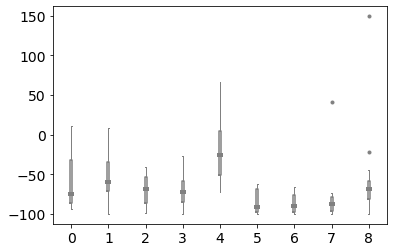

In [198]:
tick_locs_x = np.arange(len(da_for_plot.time.values))
x1 = tick_locs_x - 0.2
x2 = tick_locs_x
x3 = tick_locs_x + 0.2
data_x_list = [x2]

bp_leg = []

color = 'grey'
# for x, y, color, group in zip(data_x_list, obs_sets, colors, set_names):
bp = plt.boxplot(da_for_plot.values, positions=x2, sym='.', widths=0.05, patch_artist=False) #, notch = True)
myfuncs.set_box_color(bp, color)
bp_leg.append(bp["boxes"][0])  

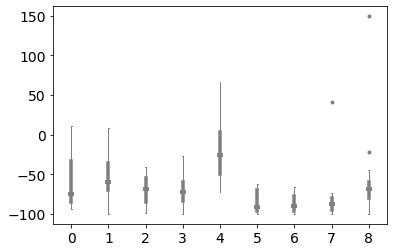

In [199]:
bp = plt.boxplot(da_for_plot.values, positions=x2, sym='.', widths=0.05, patch_artist=True) #, notch = True)
myfuncs.set_box_color(bp, color)

In [150]:
import calendar

for month_idx in range(1, 13):
    print (calendar.month_name[month_idx])
    print (calendar.month_abbr[month_idx])
    print ("")

January
Jan

February
Feb

March
Mar

April
Apr

May
May

June
Jun

July
Jul

August
Aug

September
Sep

October
Oct

November
Nov

December
Dec



In [102]:
da_temp = da_flow_lt_monClim.rename({'month': 'time'}).assign_coords({'time': pd.date_range('2017-01-01', freq='M', periods=12)}).resample(time="QS-DEC").mean()
da_temp

<xarray.DataArray 'Flow' (station: 8, time: 5)>
array([[ 1876.26350769,   531.11444211,  1541.87469474,  2018.22745263,
         1597.39048421],
       [ 4167.10960451,  1174.41397895,  4922.14661053,  4660.61381015,
         3812.11840202],
       [19655.12282795,  5358.8783504 , 12449.53182898, 11534.70822395,
        14974.29952129],
       [ 3691.06386226,  1428.27741054,  2153.1580062 ,  3320.57805594,
         3500.42991338],
       [ 2308.50915701,   676.76826066,  2467.93103041,  2902.01282024,
         2543.82600304],
       [ 1245.01059075,   314.59870952,   384.45680555,   498.17482717,
          592.23380981],
       [ 3296.60614193,  1094.00950135,  3397.48290081,  2791.07902779,
         3156.63963128],
       [ 3881.56849024,   942.20218867,  1788.67072921,  2218.75761375,
         3044.56390507]])
Coordinates:
  * station  (station) int64 418005 418014 418015 ... 418025 418027 418032
  * time     (time) datetime64[ns] 2016-12-01 2017-03-01 ... 2017-12-01

In [98]:
sns.color_palette("dark:salmon_r", 8)

[(0.9803921568627451, 0.5019607843137255, 0.4470588235294118),
 (0.8676134833274869, 0.45049529820548295, 0.40286851507891225),
 (0.7517020688606937, 0.3976002152609004, 0.35745069806034335),
 (0.6389233953254354, 0.34613472915265786, 0.3132603896098438),
 (0.5230119808586423, 0.2932396462080753, 0.26784257259127486),
 (0.41023330732338403, 0.24177416009983277, 0.22365226414077535),
 (0.29432189285659094, 0.1888790771552502, 0.17823444712220643),
 (0.18154321932133266, 0.1374135910470077, 0.13404413867170692)]

In [110]:
sns.color_palette("viridis", 10)

[(0.283072, 0.130895, 0.449241),
 (0.262138, 0.242286, 0.520837),
 (0.220057, 0.343307, 0.549413),
 (0.177423, 0.437527, 0.557565),
 (0.143343, 0.522773, 0.556295),
 (0.119512, 0.607464, 0.540218),
 (0.166383, 0.690856, 0.496502),
 (0.319809, 0.770914, 0.411152),
 (0.525776, 0.833491, 0.288127),
 (0.762373, 0.876424, 0.137064)]

In [109]:
sns.color_palette("Blues", 10)

[(0.8978854286812764, 0.939038831218762, 0.977362552864283),
 (0.828881199538639, 0.8937639369473279, 0.954725105728566),
 (0.7506343713956171, 0.8478431372549019, 0.9282122260668974),
 (0.6325259515570935, 0.7976470588235294, 0.8868742791234141),
 (0.491764705882353, 0.7219684736639754, 0.8547789311803152),
 (0.36159938485198, 0.6427374086889658, 0.8165782391387928),
 (0.24816608996539793, 0.5618915801614763, 0.7709803921568628),
 (0.15072664359861593, 0.4644521337946943, 0.7207843137254902),
 (0.07481737793156479, 0.3732564398308343, 0.6552095347943099),
 (0.03137254901960784, 0.28161476355247983, 0.5582622068435218)]

In [18]:
# read in the streamflow data using the read_csv function by specifying a header

basin_sel = 'Gwydir'
stn_Nos_basin = df_stn['AWRC Statiion Number'].values[df_stn['Basin'] == basin_sel]

# list containing data for all stations
list_ds = []

# some check arrays
list_count_nan = []
list_start_date = []

for iStn in range(len(stn_Nos_basin)):
    test_file = data_dir + str(stn_Nos_basin[iStn]) + '_daily_ts.csv'
    df_test = pd.read_csv(test_file, header = 26)
    
    # get dates in format datetime64
    date_array = pd.date_range(df_test['Date'][0], periods=len(df_test), freq="D")
    df_test['Date'] = date_array
    list_start_date.append(df_test['Date'][0])
    
    df_test = df_test.set_index(['Date'])
    # print(df_test['Date'].values[-1])  # to check that the timeseries all end consistently on 28 Feb 2022
    
    list_count_nan.append(sum(np.isnan(df_test['Flow (ML)'].values)))
    list_ds.append(df_test.to_xarray().rename({'Flow (ML)': 'Flow'}))
    
# create an xarray data array containing the data at all the stations
ds_flow = xr.concat(list_ds, dim = 'station').assign_coords({'station': stn_Nos_basin}).rename({'Date': 'time'})
ds_flow['Flow'] = ds_flow['Flow'].assign_attrs({'units': 'ML'})
ds_flow = ds_flow.assign_attrs({'Source': 'http://www.bom.gov.au/water/hrs/'})

In [19]:
ds_flow

<xarray.Dataset>
Dimensions:       (time: 17878, station: 8)
Coordinates:
  * time          (time) datetime64[ns] 1970-03-20 1970-03-21 ... 2019-02-28
  * station       (station) int64 418005 418014 418015 ... 418025 418027 418032
Data variables:
    Flow          (station, time) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    Bureau QCode  (station, time) object nan nan nan nan nan ... 'E' 'E' 'E' 'E'
Attributes:
    Source:   http://www.bom.gov.au/water/hrs/

In [20]:
list_start_date

[Timestamp('1970-10-15 00:00:00'),
 Timestamp('1970-09-12 00:00:00'),
 Timestamp('1970-03-20 00:00:00'),
 Timestamp('1978-11-30 00:00:00'),
 Timestamp('1977-07-30 00:00:00'),
 Timestamp('1978-06-15 00:00:00'),
 Timestamp('1970-07-02 00:00:00'),
 Timestamp('1979-05-26 00:00:00')]

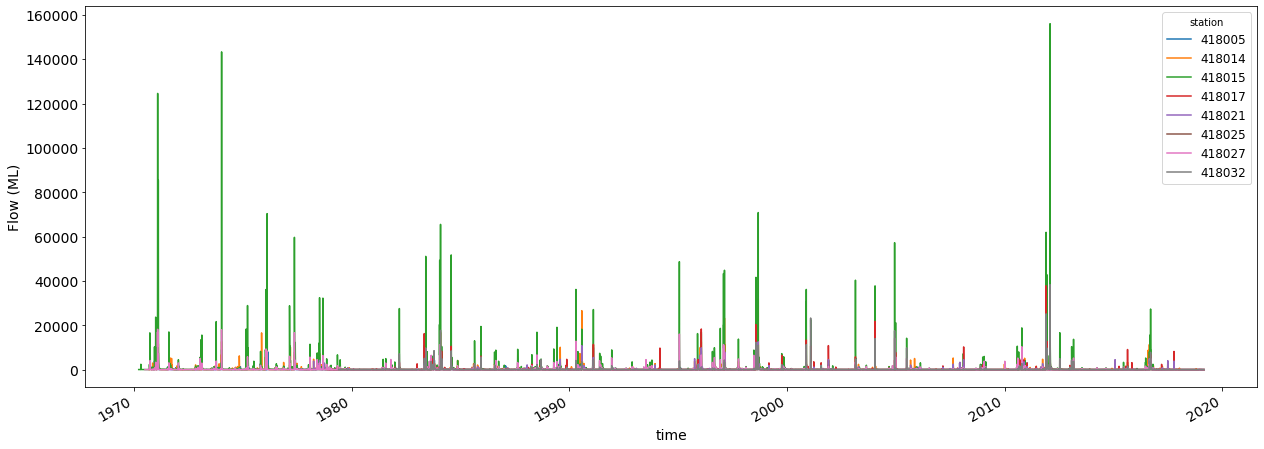

In [82]:
ds_flow['Flow (ML)'].plot(hue = 'station', size = 7, aspect = 3)

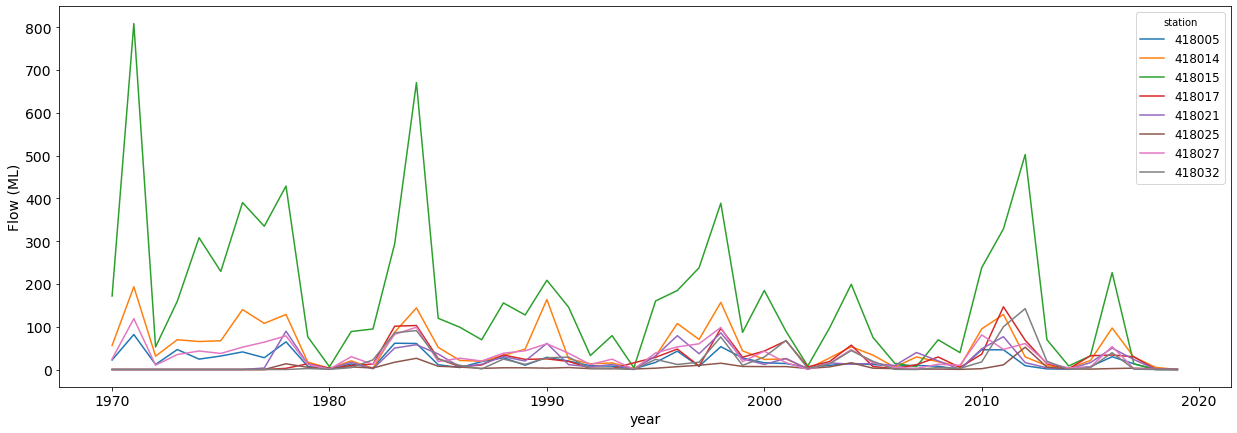

In [83]:
(ds_flow['Flow (ML)'].groupby('time.year').sum()/1000).plot(hue = 'station', size = 7, aspect = 3)

In [49]:
# monthly and seasonal anomalies in streamflow 

baseline2 = slice('1996-01-01', '2020-05-31')

vname = 'Flow'

# convert daily streamflow to monthly values
da_flow_mon = ds_flow[vname].resample(time = '1M').sum()

In [50]:
da_flow_mon

<xarray.DataArray 'Flow' (station: 8, time: 588)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        5.97715200e+02, 1.58976000e+01, 3.36960000e+00],
       [5.64030742e+02, 4.70664991e+03, 1.60750490e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.21611268e+01, 6.32598142e+01, 5.35807169e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.94605706e+02, 4.31894608e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])
Coordinates:
  * station  (station) int64 418005 418014 418015 ... 418025 418027 418032
  * time     (time) datetime64[ns] 1970-03-31 1970-04-30 ... 2019-02-28

In [63]:
# the monthly climatology from long-term data
baseline1 = slice('1981-01-01', '2020-05-31')
da_flow_lt_monClim = da_flow_mon.sel(time = baseline1).groupby('time.month').mean('time')

# the monthly anomalies during the drought period
time_slice = slice('2016-12-01', '2020-12-31')
da_flow_monAnom = ((da_flow_mon.sel(time = time_slice).groupby('time.month') - da_flow_lt_monClim)/1000).assign_attrs({'units': 'GL'})

# monthly anomalies in %
da_flow_monAnom_perc = (da_flow_mon.sel(time = time_slice).groupby('time.month') - da_flow_lt_monClim).groupby('time.month')/da_flow_lt_monClim*100

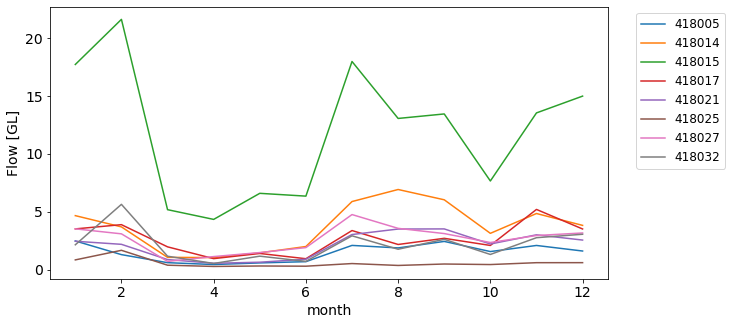

In [82]:
(da_flow_lt_monClim/1000).assign_attrs({'units': 'GL'}).plot(hue = 'station', size=5, aspect=2, label=da_flow_monAnom.station.values)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

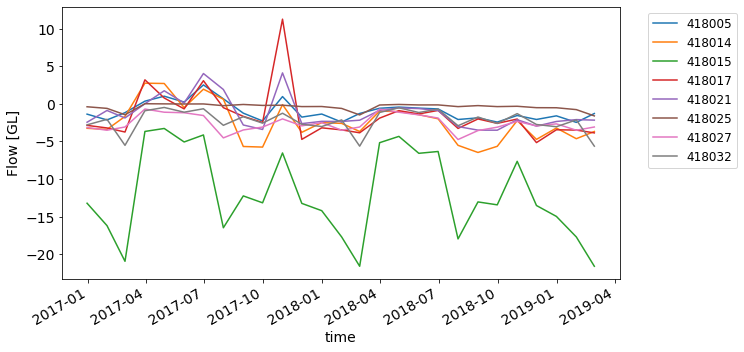

In [81]:
da_flow_monAnom.plot(hue = 'station', size=5, aspect=2, label=da_flow_monAnom.station.values) #, ylim = (-1000, 1000))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


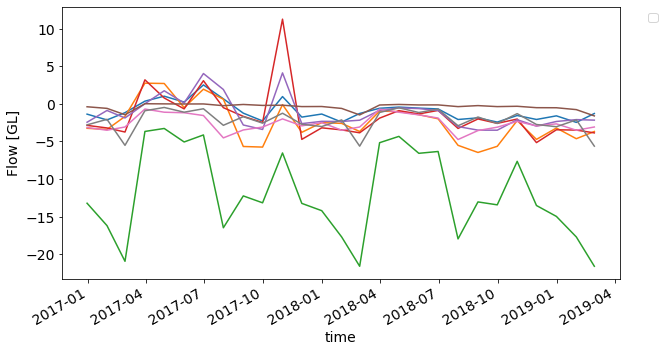

In [77]:
kwargs = {'legend': None}
da_flow_monAnom.plot(hue = 'station', size=5, aspect=2, label=None) #, ylim = (-1000, 1000))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

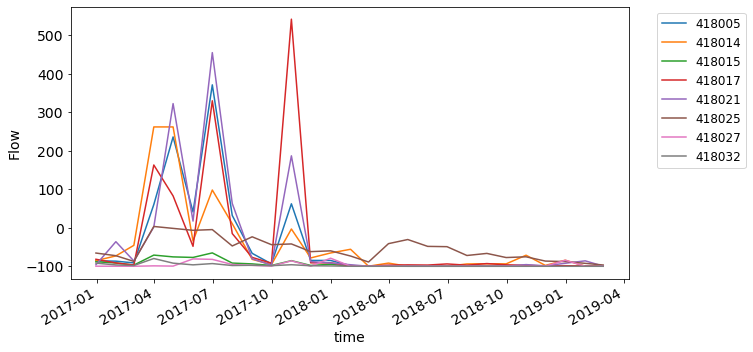

In [83]:
da_flow_monAnom_perc.plot(hue = 'station', size=5, aspect=2, label=da_flow_monAnom.station.values) #, ylim = (-1000, 1000))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

### Monthly and seasonal anomaly plots

In [90]:
nStations = len(da_flow_monAnom.station.values)

In [92]:
sns.color_palette()[0:nStations]

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)]

In [87]:
import seaborn as sns
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [95]:
x = sns.color_palette()
len(x)

10

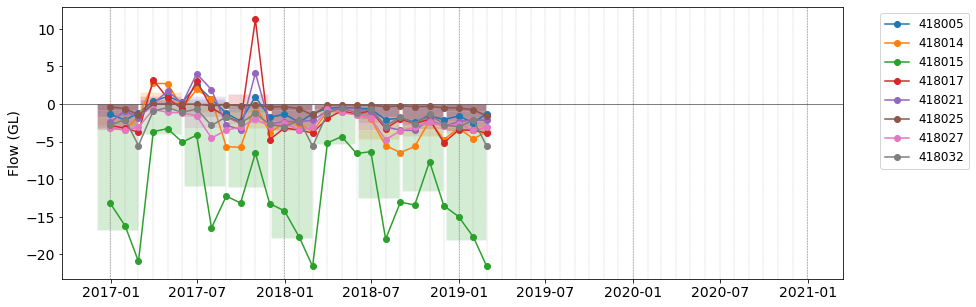

In [93]:
out_dir = 'figures/drought_2017to2020/PminusE/'
col_sel = ['gray', 'orange', 'royalblue']

nStations = len(da_flow_monAnom.station.values)
col_sel = sns.color_palette()[0:nStations]

data_list = [da_flow_monAnom.sel(station = s) for s in da_flow_monAnom.station.values]
data_names = da_flow_monAnom.station.values

# da_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
for da, color, label in zip(data_list, col_sel, data_names):       
    plt.plot(da.time.values, da.values, marker='o', color=color, label=label)
    
    xx = da.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
    array_time = [x.astype('datetime64[D]') for x in xx]
    array_val = da.resample(time="QS-DEC").mean().values
    plt.bar(array_time, array_val, width=85, edgecolor='white', color=color, alpha=0.2)
             #ecolor='lightsteelblue', elinewidth=3, capsize=0)
#da_sm_monAnom_regAvg.plot.line(color="royalblue", marker="o", linewidth=1)
plt.xlabel('')
plt.ylabel('Flow (GL)')
#plt.ylim((-40, 40))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

#fig.savefig(out_dir + 'areaAvg_PminusE_anom_from_monClim_inmm.png', bbox_inches='tight')

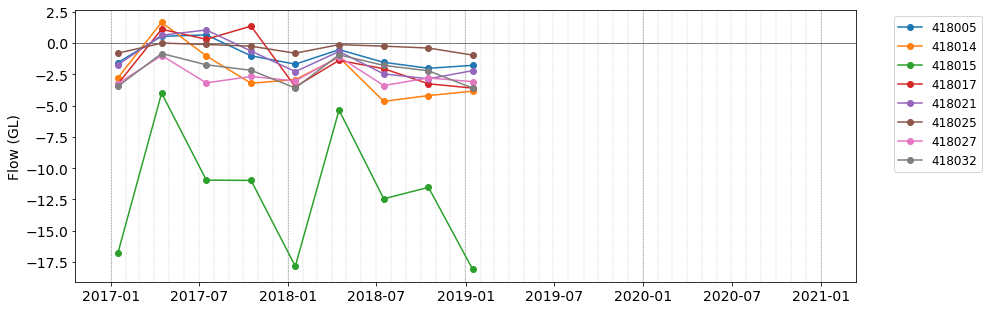

In [94]:
out_dir = 'figures/drought_2017to2020/PminusE/'

nStations = len(da_flow_monAnom.station.values)
col_sel = sns.color_palette()[0:nStations]

data_list = [da_flow_monAnom.sel(station = s) for s in da_flow_monAnom.station.values]
data_names = da_flow_monAnom.station.values

# da_allDatamean = xr.concat(data_list, dim = 'data').mean('data')

fig, ax = plt.subplots(nrows=1,ncols=1,
                    figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2016-12-31', freq='M', periods=12*4+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2016-12-31', freq='Y', periods=5).to_numpy()

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)

plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
for da, color, label in zip(data_list, col_sel, data_names):       
    #plt.plot(da.time.values, da.values, marker='o', color=color, label=label)
    
    xx = da.resample(time="QS-DEC").mean().time.values + np.timedelta64(45, 'D')
    array_time = [x.astype('datetime64[D]') for x in xx]
    array_val = da.resample(time="QS-DEC").mean().values
    plt.plot(array_time, array_val, marker='o', color=color, label=label)
    # plt.bar(array_time, array_val, width=85, edgecolor='white', color=color, alpha=0.2)
             #ecolor='lightsteelblue', elinewidth=3, capsize=0)
#da_sm_monAnom_regAvg.plot.line(color="royalblue", marker="o", linewidth=1)
plt.xlabel('')
plt.ylabel('Flow (GL)')
#plt.ylim((-40, 40))
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

#fig.savefig(out_dir + 'areaAvg_PminusE_anom_from_monClim_inmm.png', bbox_inches='tight')

In [86]:
df_stn['Catchment Area (km2)'].values[df_stn['Basin'] == basin_sel]

array([ 249.3,  834.6, 1955. ,  865.2,  346. ,  126.4,  204.9,  872.6])

In [87]:
df_stn['AWRC Statiion Number'].values[df_stn['Basin'] == basin_sel]

array([418005, 418014, 418015, 418017, 418021, 418025, 418027, 418032])

In [62]:
#df_test['Flow (ML)'].to_xarray()
rename_dict = {'Flow (ML)': 'Flow_' + str(stn_Nos_basin[0]),
              'Bureau QCode': 'QCode_' + str(stn_Nos_basin[0])}

df_test.to_xarray()#.rename(rename_dict).assign_coords

<xarray.Dataset>
Dimensions:       (Date: 14524)
Coordinates:
  * Date          (Date) datetime64[ns] 1979-05-26 1979-05-27 ... 2019-02-28
Data variables:
    Flow (ML)     (Date) float64 6.221 6.134 6.307 6.912 ... 0.0 0.0 0.0 0.0
    Bureau QCode  (Date) object 'E' 'E' 'E' 'E' 'E' 'E' ... 'E' 'E' 'E' 'E' 'E'

In [28]:
pd.date_range(df_test['Date'][0], periods=len(df_test), freq="D")

DatetimeIndex(['1957-03-31', '1957-04-01', '1957-04-02', '1957-04-03',
               '1957-04-04', '1957-04-05', '1957-04-06', '1957-04-07',
               '1957-04-08', '1957-04-09',
               ...
               '2019-02-19', '2019-02-20', '2019-02-21', '2019-02-22',
               '2019-02-23', '2019-02-24', '2019-02-25', '2019-02-26',
               '2019-02-27', '2019-02-28'],
              dtype='datetime64[ns]', length=22615, freq='D')

In [15]:
df_stn

,AWRC Statiion Number,Station Name,Latitude,Longitude,Jurisdiction,Catchment Area (km2),Data Owner Name,Data Owner Code,Basin,Randomness test result (from webpage),Trend (from webpage),Step Change (from webpage),Change year (from webpage)
0,410713,Paddy's River at Riverlea,-35.384300,148.965600,ACT,224.4,Icon Water Limited,w00002,Murrumbidgee,NaN,NaN,NaN,NaN
1,410730,Cotter River at Gingera,-35.591700,148.821250,ACT,130.0,Icon Water Limited,w00002,Murrumbidgee,NaN,NaN,NaN,NaN
2,410731,Gudgenby River at Tennent,-35.574851,149.066250,ACT,671.6,"Environment, Planning and Sustainable Developm...",w00075,Murrumbidgee,NaN,NaN,NaN,NaN
3,410734,Queanbeyan River at Tinderry,-35.613750,149.349819,ACT,563.7,Icon Water Limited,w00002,Murrumbidgee,NaN,NaN,NaN,NaN
4,410705,Molonglo River at Burbong,-35.336700,149.316250,ACTNSW,508.6,"Environment, Planning and Sustainable Developm...",w00075,Murrumbidgee,NaN,NaN,NaN,NaN
5,410761,Murrumbidgee River below Lobbs Hole Creek,-35.539928,149.101250,ACTNSW,5158.0,"Environment, Planning and Sustainable Developm...",w00075,Murrumbidgee,NaN,NaN,NaN,NaN
6,410024,Goodradigbee River at Wee Jasper (Kashmir),-35.167200,148.685500,NSW,990.0,NSW Department of Industry Lands and Water,w00077,Murrumbidgee,NaN,NaN,NaN,NaN
7,410026,Yass River at Yass,-34.836700,148.910300,NSW,1229.0,NSW Department of Industry Lands and Water,w00077,Murrumbidgee,NaN,NaN,NaN,NaN
8,410033,Murrumbidgee River at Mittagang Crossing,-36.170000,149.090000,NSW,1890.0,NSW Department of Industry Lands and Water,w00077,Murrumbidgee,NaN,NaN,NaN,NaN
9,410038,Adjungbilly Creek at Darbalara,-35.019200,148.245700,NSW,390.9,NSW Department of Industry Lands and Water,w00077,Murrumbidgee,NaN,NaN,NaN,NaN
